<a href="https://colab.research.google.com/github/Arthur-ca/MIE1517/blob/Jing-Guo/Team23_Final_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Team 23 Project: Facial Expression Detection**

## Introduction

The field of automatic emotion recognition represents a significant interdisciplinary nexus, where the intricacies of human psychology intersect with the advancements in artificial intelligence.

In our collaborative project, we aim to develop an Emotion Detection model.
Our approach harnesses Dlib's facial detection and landmark prediction to isolate key facial features—specifically the eyes, eyebrows, and mouth. These elements are then compiled against a black backdrop, streamlining the complexity for the subsequent phase. We employ a Convolutional Neural Network (CNN) to train on these consolidated regions, aiming to accurately predict a spectrum of emotions: neutrality, surprise, anger, contempt, sadness, fear, happiness, and disgust.

This method, we believe, reduces complexity and amplifies feature learning, paving the way for robust, accurate emotion detection.

## Illustration

Please refer to the accompanying illustration for a visual representation of our project's purpose. We endeavor to discern various emotions from facial images through our model.

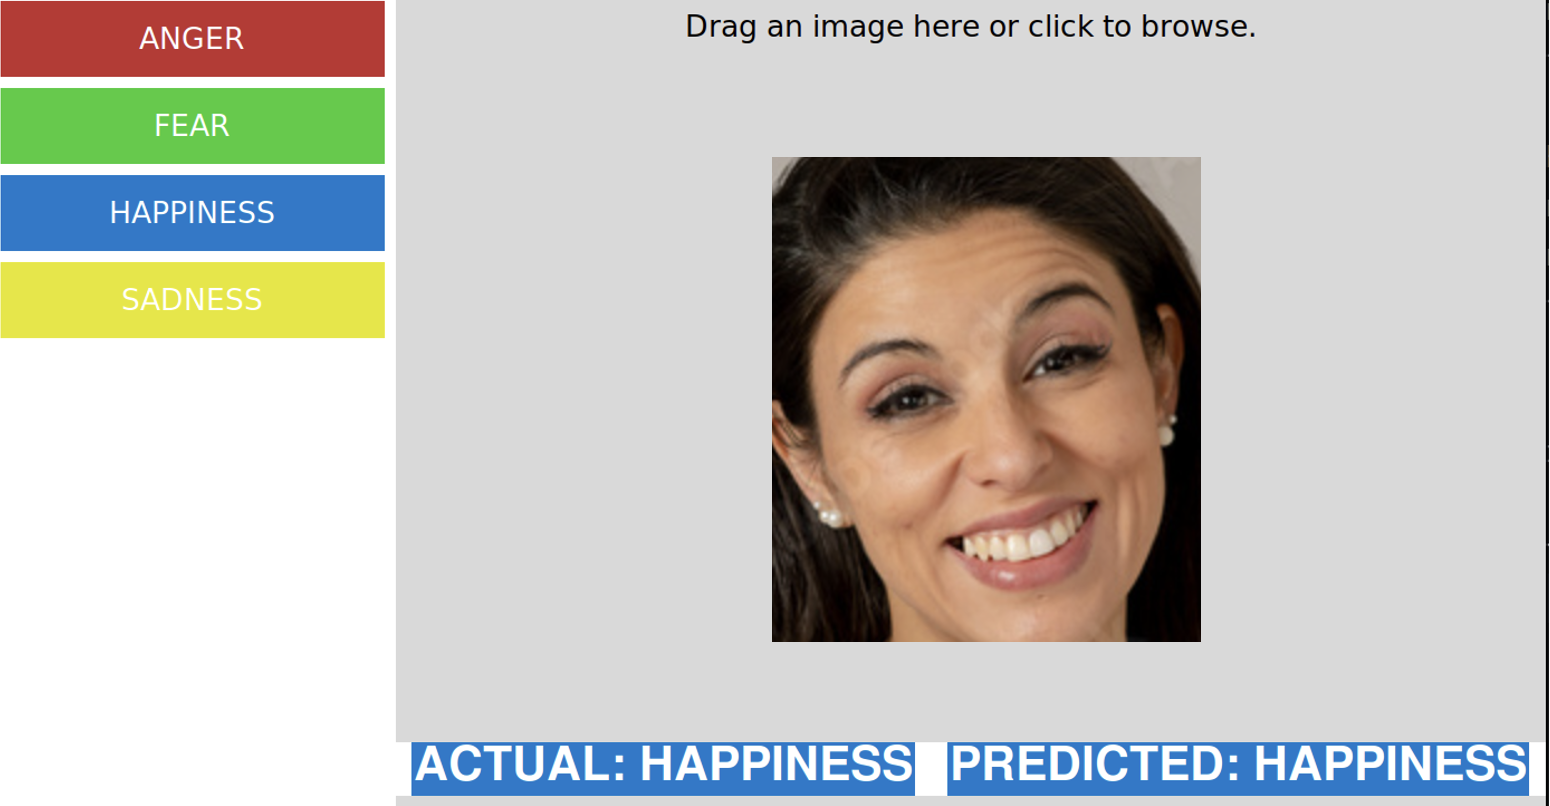

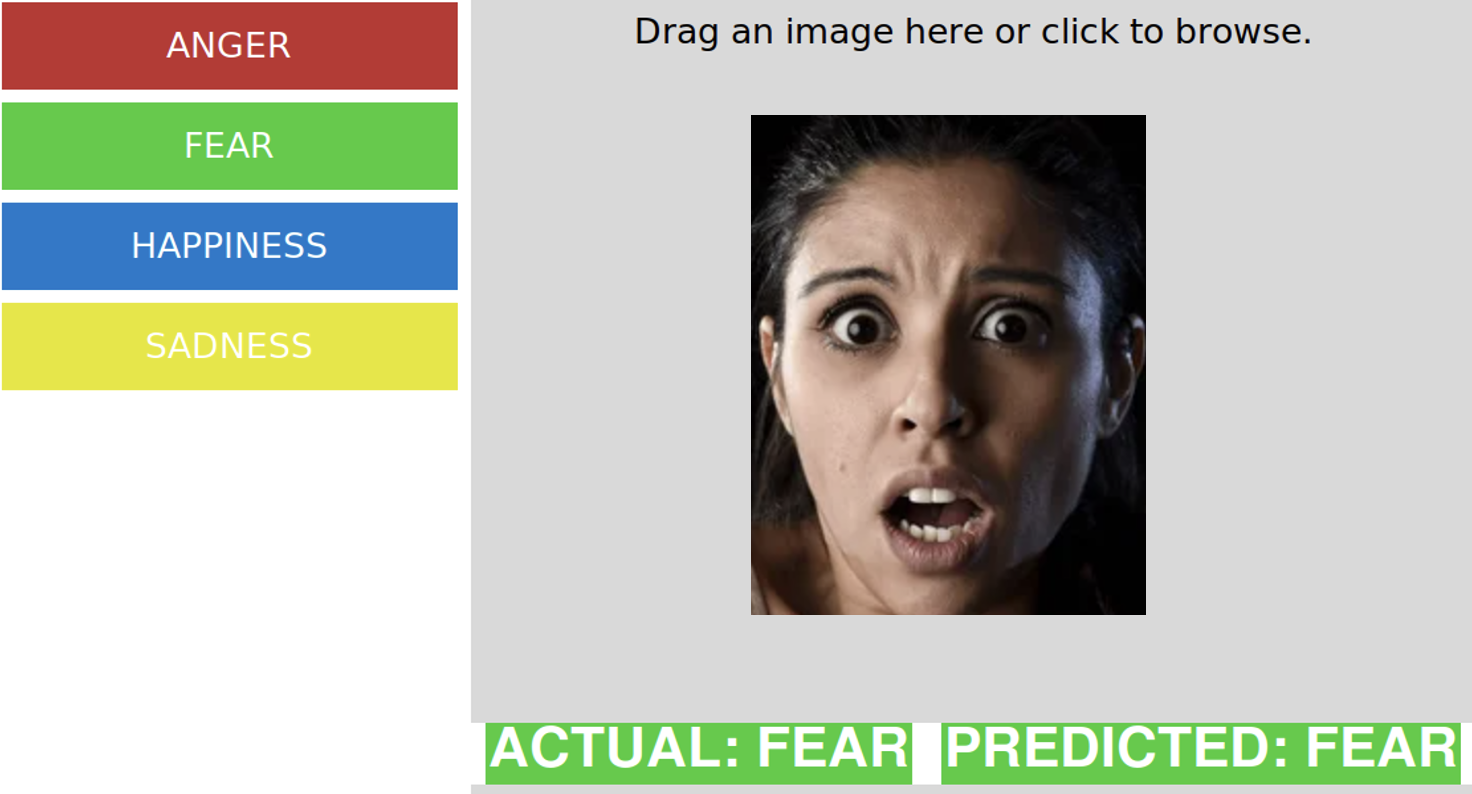<a href="https://colab.research.google.com/github/Arthur-ca/MIE1517/blob/Jing-Guo/FinalProjectCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

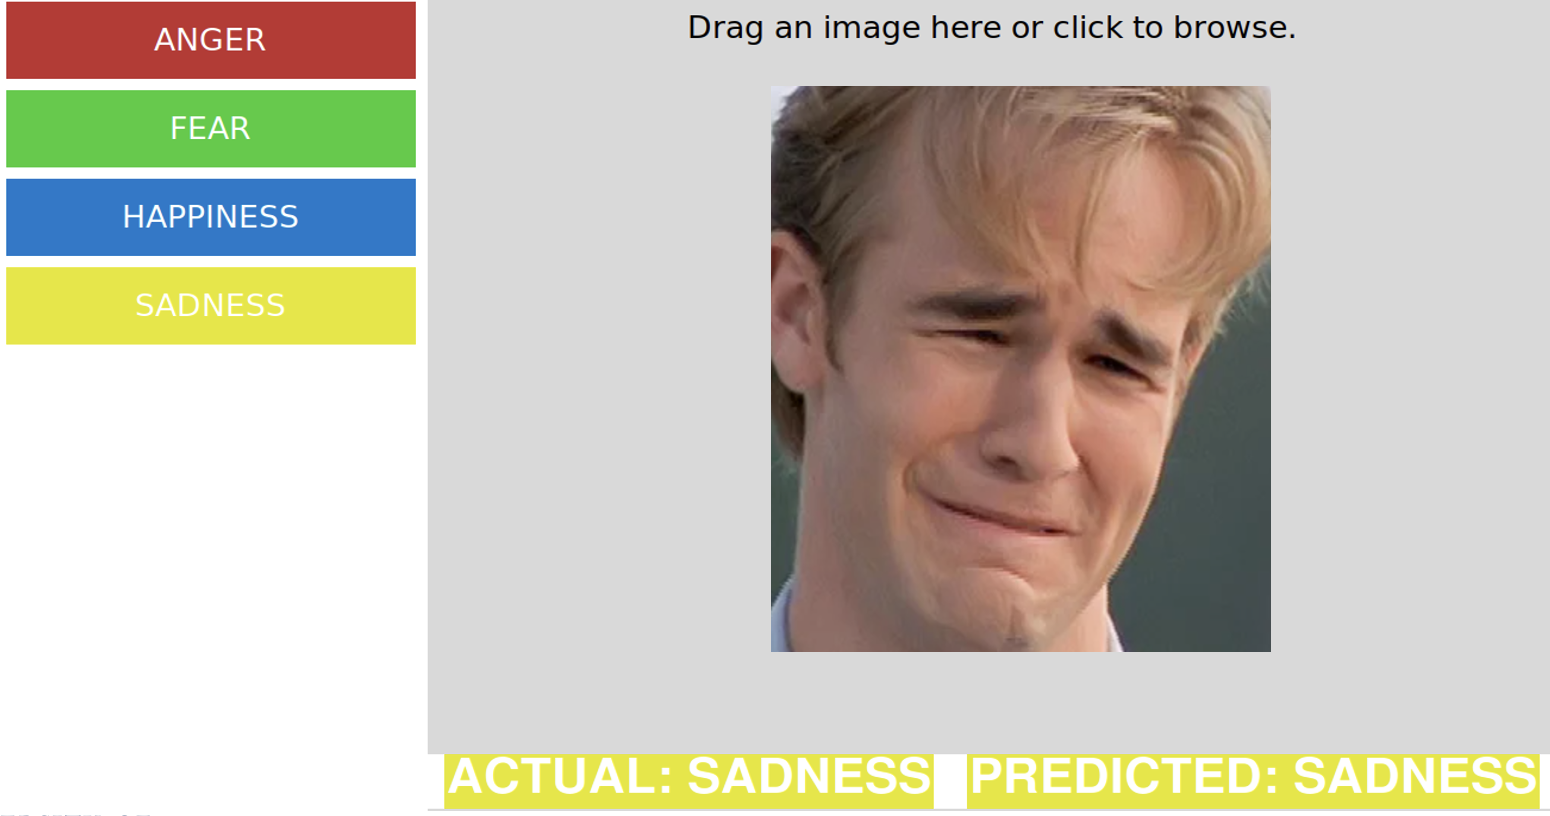

## Data Review and Processing
There are 5,500 + images with 8 emotions categories – anger, contempt, disgust, fear, happiness, neutrality, sadness and surprise. All images contain grayscale human face (or sketch). Each image is 224 x 224 pixel grayscale in PNG format.

Link for the data:
https://www.kaggle.com/datasets/sudarshanvaidya/random-images-for-face-emotion-recognition?select=happiness

In [ ]:
import torch
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import torchvision
from torchvision import datasets, models
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F1
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.datasets import ImageFolder
# import tensorflow as tf
import gc
from collections import Counter
import imgaug.augmenters as iaa
import cv2
import dlib
from collections import defaultdict
from matplotlib import pyplot as plt
import itertools


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Below shows all the classes of emotions from the original dataset

In [ ]:
# All the classes of emotions we have
classeses = []
for i in os.listdir('/content/gdrive/My Drive/ColabNotebooks/archive'):
    if i!=5:
        classeses.append(i)
classeses

['neutrality',
 'sadness',
 'fear',
 'surprise',
 'contempt',
 'happiness',
 'anger',
 'disgust']

Data loading

In [ ]:
classes = os.listdir('/content/gdrive/My Drive/ColabNotebooks/archive')

# Initialize empty lists for features (transformed images) and labels
features = []
labels = []
def create_train():
    for i, photo in enumerate(classes):
        path = os.path.join('/content/gdrive/My Drive/ColabNotebooks/archive', photo)
        label = i  # Use the index of the class as the label

        # Loop over to get every image in the current class
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img_pil = cv2.imread(img_path)

            if img_pil is None:
                print("Error loading image:", img_path)
                continue
            #Append the original image and its label to the list
            features.append(np.array(img_pil))
            labels.append(label)

create_train()
label_counts = Counter(labels)
for label, count in label_counts.items():
    print(f"Label {label} {classeses[label]}: {count} images")

Label 0 neutrality: 524 images
Label 1 sadness: 746 images
Label 2 fear: 570 images
Label 3 surprise: 785 images
Label 4 contempt: 208 images
Label 5 happiness: 1406 images
Label 6 anger: 890 images
Label 7 disgust: 439 images


Brief visualization of the dataset

In [ ]:
# Define a function for visualization
def plot_first_n_images(images, labels, classes, n=5):
    num_unique_labels = len(np.unique(labels))  # Get the number of unique labels
    fig, axes = plt.subplots(num_unique_labels, n, figsize=(n*2, num_unique_labels*2))

    # Initialize a dictionary to store image indices for each label
    label_indices = defaultdict(list)

    # Populate the dictionary with indices of images for each label
    for index, label in enumerate(labels):
        label_indices[label].append(index)

    # Plot 'n' images for each unique label
    for label_idx, label in enumerate(np.unique(labels)):
        indices = label_indices[label][:n]  # Get the first 'n' indices for this label
        for img_idx, img_index in enumerate(indices):
            axes[label_idx, img_idx].imshow(images[img_index], cmap='gray')
            axes[label_idx, img_idx].set_title(f"Label: {classes[label]}")
            axes[label_idx, img_idx].axis('off')

    plt.tight_layout()
    plt.show()

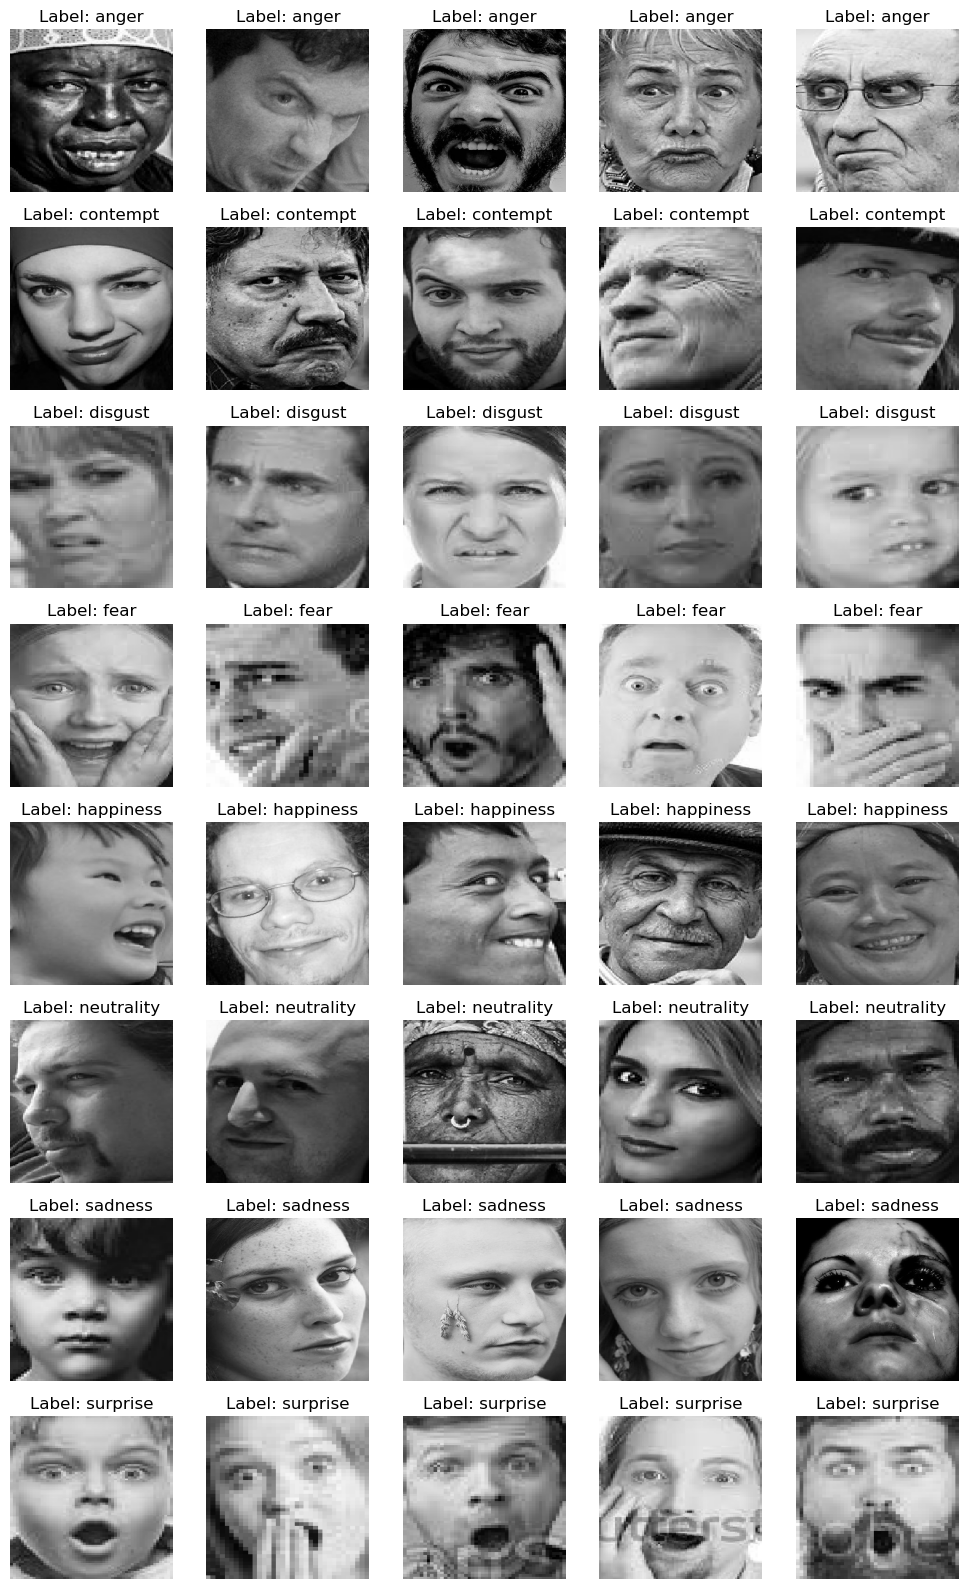

In [ ]:
plot_first_n_images(features, labels, classeses, n=5)

## Applying image to DLIB

### Brief description of Dlib & how we process with it
Dlib's face detector is a pre-trained machine learning model based on Histogram of Oriented Gradients (HOG) features and Support Vector Machines (SVM). When we feed it a grayscale image, it returns rectangles, each of which encloses a detected face.

Once a face is detected, we use Dlib's landmark predictor, which is trained on a large dataset of faces with known landmarks. It maps 68 points onto the face within the detected rectangle, outlining facial contours and features as below figure

We focus on extracting the eyes, eyebrows, and mouth regions, and combined the extracted part together into a black background. These areas are rich in emotional information and critical for accurate emotion classification.

Downloading Dlib Package

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

In [ ]:
#Data processing performed
# Initialize Dlib's face detector (HOG-based) and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/gdrive/My Drive/ColabNotebooks/shape_predictor_68_face_landmarks.dat')

# Function to extract and combine eyes, eyebrows, and mouth into a single image
def extract_and_combine_regions(gray, landmarks):
    # Create masks for eyes including eyebrows and mouth
    mask_eyes_eyebrows = np.zeros_like(gray)
    mask_mouth = np.zeros_like(gray)

    # Points for eyes and eyebrows
    # By concatenating the eye and eyebrow points, we maintain the relative positioning of these features,
    # which is vital for capturing expressions like surprise or frowning, as opposed to analyzing them separately which could lose contextual information
    eyes_eyebrows_points = np.concatenate([
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 27)]),  # Eyebrows
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 48)])   # Eyes
    ])

    # Points for mouth
    mouth_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)])  # Mouth

    # Fill the masks with the polygons defined by points
    cv2.fillPoly(mask_eyes_eyebrows, [eyes_eyebrows_points], 255)
    cv2.fillPoly(mask_mouth, [mouth_points], 255)

    # Use the masks to extract the regions from the image
    eyes_eyebrows_region = cv2.bitwise_and(gray, mask_eyes_eyebrows)
    mouth_region = cv2.bitwise_and(gray, mask_mouth)

    # Combine the regions on a black background
    combined_image = np.zeros_like(gray)
    combined_image[mask_eyes_eyebrows == 255] = eyes_eyebrows_region[mask_eyes_eyebrows == 255]
    combined_image[mask_mouth == 255] = mouth_region[mask_mouth == 255]

    return combined_image

Creat image for the extracted part together into a black background

In [ ]:
# Initialize lists to store the processed data and any indices of images that failed to process
features_or = []
labels_or = []
train_data_or = []
failed_indices = []
# Define a function to process images in a given dataset
def create_images():
    # Iterate over each class in the dataset
    for i, photo in enumerate(classeses):
        # Construct the path to the directory containing images of the class
        path = os.path.join('/content/gdrive/My Drive/ColabNotebooks/archive', photo)
        label = i  # Use the index of the class as the label
        # Iterate over each image in the class directory
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            # Skip processing if the image could not be loaded
            if img is None:
                continue

            # Convert the image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Apply CLAHE to improve the contrast locally
            # CLAHE is particularly beneficial for images with uneven lighting or where important details
            # are lost in shadow or highlights.
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            gray_clahe = clahe.apply(gray)

            # Detect faces in the CLAHE preprocessed image
            faces = detector(gray_clahe, 1)

            # If no faces are detected with CLAHE, try standard histogram equalization
            # Histogram equalization improves the global contrast of an image by effectively spreading out the most frequent intensity values.
            # However, it can sometimes over-enhance contrast or amplify noise, which is why it is our fallback method,
            if len(faces) == 0:
                gray_eq = cv2.equalizeHist(gray)
                faces = detector(gray_eq, 1)
                image_to_use = gray_eq
            else:
                image_to_use = gray_clahe
            # If faces are detected, proceed to landmark prediction
            if len(faces) > 0:
                face = faces[0]
                # Predict facial landmarks using the Dlib predictor
                landmarks = predictor(image_to_use, face)
                # Extract and combine regions of interest (eyes, eyebrows, and mouth) into one image
                combined_region = extract_and_combine_regions(image_to_use, landmarks)
                # Append the combined image and its label to the list
                features_or.append(combined_region)
                labels_or.append(label)
                train_data_or.append([combined_region, label])
            else:
                # Keep track of images where no face was detected
                failed_indices.append(i)

create_images()
# Print the label counts
label_counts_or = Counter(labels_or)
for label, count in label_counts_or.items():
    print(f"Label {label} {classeses[label]}: {count} images")

Label 0 neutrality: 419 images
Label 1 sadness: 448 images
Label 2 fear: 372 images
Label 3 surprise: 610 images
Label 4 contempt: 142 images
Label 5 happiness: 896 images
Label 6 anger: 585 images
Label 7 disgust: 292 images


Plot the graph with extracted region

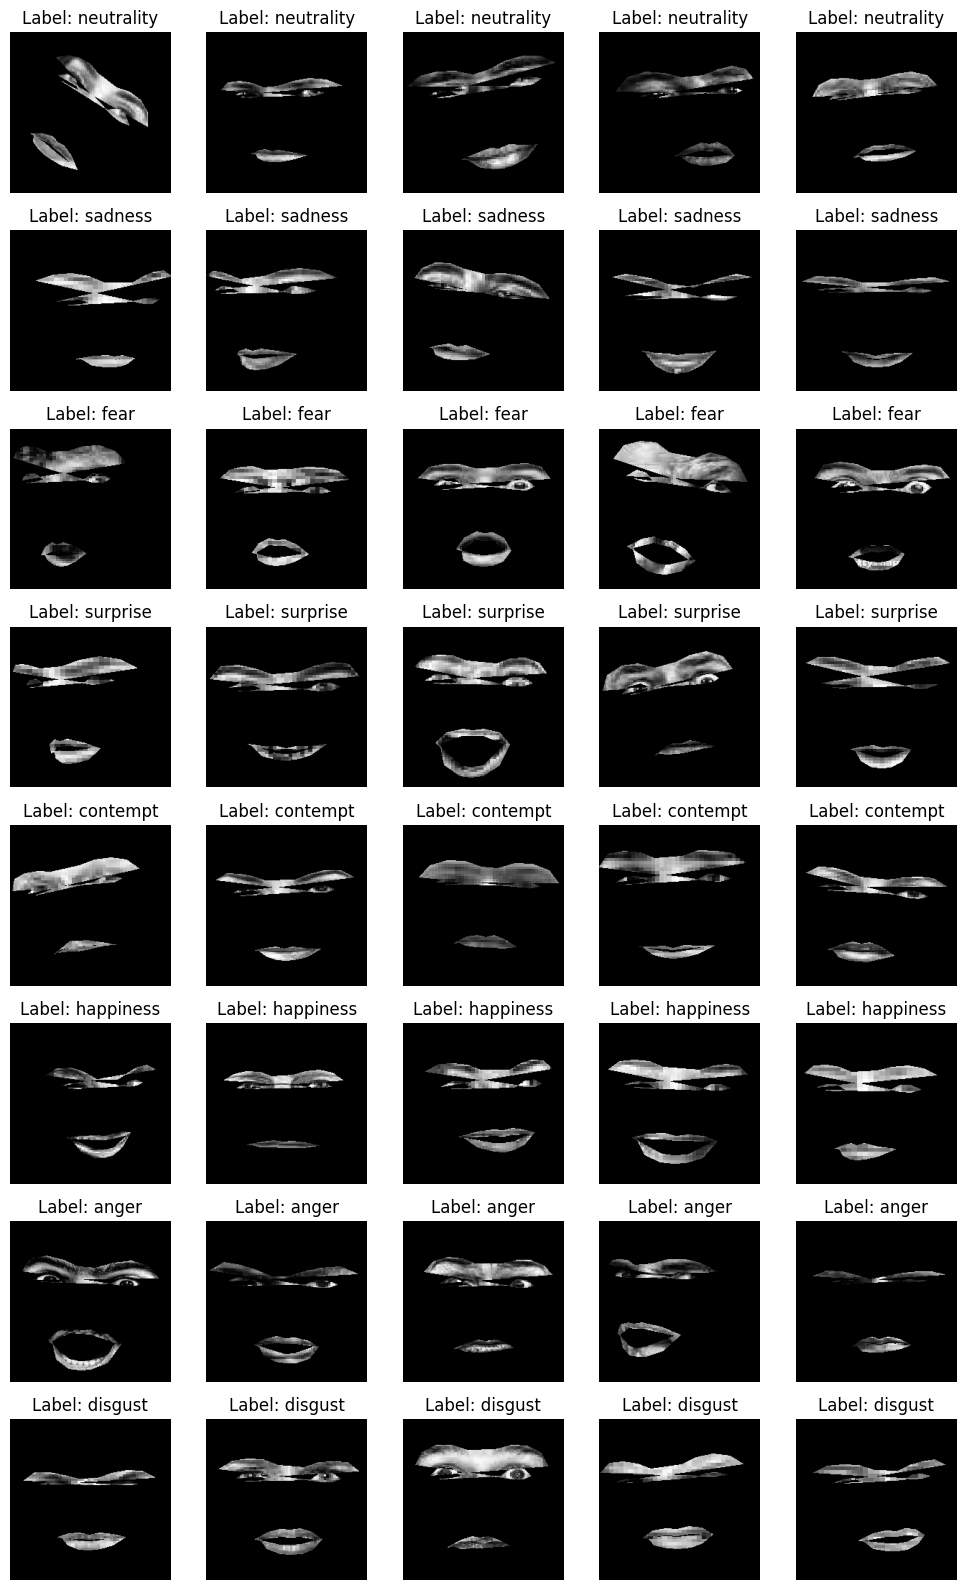

In [ ]:
plot_first_n_images(features_or, labels_or, classeses, n=5)

## Implentation

### We first starts with 2 class: Happiness and Sadness from our extracted image

In [ ]:
# Extract sadness and happiness
features_or_array = np.array(features_or)  # Convert features to a NumPy array for indexing
labels_or_array = np.array(labels_or)  # Convert labels to a NumPy array for indexing

# Define the labels you want to extract
desired_labels = [1, 5]
for i in desired_labels:
  print("Class: ", classeses[i])
# Create a mask to filter the indices corresponding to the desired labels
mask = np.isin(labels_or_array, desired_labels)

# Extract features and labels corresponding to the desired labels
features_filtered = features_or_array[mask]
labels_filtered = labels_or_array[mask]
# Verify the shapes and sizes of the extracted features and labels
label_counts_or_filtered = Counter(labels_filtered)
for label, count in label_counts_or_filtered.items():
    print(f"Label {label} {classeses[label]}: {count} images")
print("Filtered Features Shape:", features_filtered.shape)
print("Filtered Labels Shape:", labels_filtered.shape)

Class:  sadness
Class:  happiness
Label 1 sadness: 448 images
Label 5 happiness: 896 images
Filtered Features Shape: (1344, 224, 224)
Filtered Labels Shape: (1344,)


In [ ]:
'''# Two class
labels_filtered = np.array(labels_filtered)
# Change value 1 to 0 and value 5 to 1
labels_filtered[labels_filtered == 1] = 0
labels_filtered[labels_filtered == 5] = 1
np.unique(labels_filtered)

array([0, 1])

Split the extracted images into train, validation, and test sets using a 60-20-20 split

In [ ]:
# Preprocess and transform the images
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add any additional transforms you might need
])
# Convert the processed images and labels into tensors and apply transforms
def prepare_dataset(images, labels, transform):
    tensor_images = [transform(image) for image in images]
    tensor_labels = torch.tensor(labels, dtype=torch.long)
    return TensorDataset(torch.stack(tensor_images), tensor_labels)

def split_and_prepare_dataset(features, labels, transform, train_percent=0.80, val_percent=0.10):
    # Use Counter to get the count of each label in the dataset
    label_counts = Counter(labels)

    # Dictionary to store the indices for each label
    label_indices = defaultdict(list)

    # Populate the dictionary with indices of images for each label
    for index, label in enumerate(labels):
        label_indices[label].append(index)

    # Dictionary to store the indices for each set
    train_indices = []
    val_indices = []
    test_indices = []

    # Iterate over unique labels and distribute their indices among train, val, and test sets
    for label, indices in label_indices.items():
        label_size = len(indices)
        train_size = int(label_size * train_percent)
        val_size = int(label_size * val_percent)

        # Add indices to each set
        train_indices.extend(indices[:train_size])
        val_indices.extend(indices[train_size:(train_size + val_size)])
        test_indices.extend(indices[(train_size + val_size):])

    # Create Subset datasets based on the sampled indices
    train_dataset = prepare_dataset(features[train_indices], labels[train_indices], transform)
    val_dataset = prepare_dataset(features[val_indices], labels[val_indices], transform)
    test_dataset = prepare_dataset(features[test_indices], labels[test_indices], transform)

    return train_dataset, val_dataset, test_dataset

In [ ]:
# split data
combined_train_dataset, combined_val_dataset, combined_test_dataset = split_and_prepare_dataset(features_filtered, labels_filtered, transform)

In [ ]:
# Check the length of each dataset
train_length = len(combined_train_dataset)
val_length = len(combined_val_dataset)
test_length = len(combined_test_dataset)

print(f"Training set length: {train_length} samples")
print(f"Validation set length: {val_length} samples")
print(f"Test set length: {test_length} samples")

Training set length: 1074 samples
Validation set length: 133 samples
Test set length: 137 samples


In [ ]:
train_labels = combined_train_dataset.tensors[1].numpy()
# Count the number of images for each unique label in the training dataset
label_counts_train = Counter(train_labels)
# Print the counts for each label
for label, count in label_counts_train.items():
    print(f"Label {label} : {count} images")

Label 0 : 268 images
Label 1 : 537 images


Data argumentation:
As our dataset is highly imbalanced, we aim to apply some argumentation(flip, rotation, ColorJitter, and blur) to our training dataset to match the max length of the largest class

In [ ]:
# Data Augmentation in train data
# Define the augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # Flip with a probability of 1 (always flip)
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
])

def balance_dataset_with_augmentation(original_train_dataset, augmentation_transforms):
    # Count the number of images for each unique label in the training set
    label_counts_train = Counter(original_train_dataset.tensors[1].numpy())

    # Determine the maximum count among all labels
    max_count = max(label_counts_train.values())

    # Apply data augmentation to balance the dataset
    augmented_images = []
    augmented_labels = []

    for label, count in label_counts_train.items():
        # Calculate the number of augmentations needed for each label
        augmentations_needed = max_count - count

        # Filter images and labels for the current label
        label_indices = [i for i, l in enumerate(original_train_dataset.tensors[1].numpy()) if l == label]
        label_images = original_train_dataset.tensors[0][label_indices]
        label_labels = original_train_dataset.tensors[1][label_indices]

        # Apply data augmentation to reach the desired count
        for _ in range(augmentations_needed):
            random_index = np.random.choice(len(label_images))
            augmented_image = augmentation_transforms(label_images[random_index])
            augmented_images.append(augmented_image)
            augmented_labels.append(label)

    # Convert augmented data to tensors
    augmented_images = torch.stack(augmented_images)
    augmented_labels = torch.tensor(augmented_labels, dtype=torch.long)

    # Combine the original and augmented data
    balanced_train_dataset = TensorDataset(torch.cat([original_train_dataset.tensors[0], augmented_images]),
                                           torch.cat([original_train_dataset.tensors[1], augmented_labels]))

    return balanced_train_dataset


In [ ]:
# Balance the train data
balanced_train_dataset = balance_dataset_with_augmentation(combined_train_dataset, augmentation_transforms)
balanced_train_labels = balanced_train_dataset.tensors[1].numpy()
# Count the number of images for each unique label in the balanced dataset
label_counts_balanced = Counter(balanced_train_labels)
# Print the counts for each label
for label, count in label_counts_balanced.items():
    print(f"Label {label} ({classes[label]}): {count} images")

Label 0 (neutrality): 537 images
Label 1 (sadness): 537 images


In [ ]:
# Create dataloader
Combined_train_loader = DataLoader(combined_train_dataset, batch_size=64, shuffle=True)
Combined_balanced_train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True)
Combined_val_loader = DataLoader(combined_val_dataset, batch_size=64, shuffle=False)
Combined_test_loader = DataLoader(combined_test_dataset, batch_size=64, shuffle=False)

### Model Architecture

In [ ]:
class CombinedCNN(nn.Module):
    def __init__(self, num_classes):
        super(CombinedCNN, self).__init__()

        # Define convolutional layers using nn.Sequential
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Assuming input channels = 1 (grayscale)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Define fully connected layers using nn.Sequential
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
        self.name = "CombinedCNN"
    def forward(self, x):
        # Apply convolutional layers
        x = self.conv_layers(x)

        # Flatten the output for the fully connected layers
        x = x.view(-1, 512 * 7 * 7)

        # Apply fully connected layers
        x = self.fc_layers(x)

        return x

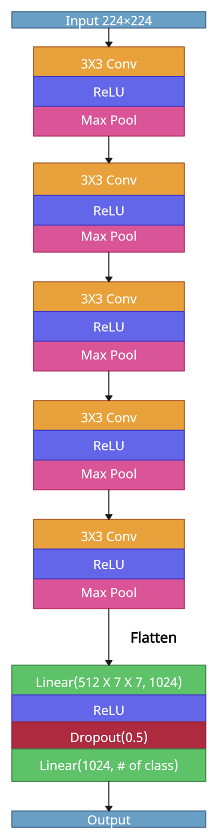

In [ ]:
class CNNetResidual3(nn.Module):
    def __init__(self, num_classes, numresidual1,numresidual2):
        super().__init__()

        # Downward path
        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(32, numresidual1)
        )

        self.downconv2 = nn.Sequential(
            nn.Conv2d((32+numresidual1), 128, kernel_size=7, padding=1,stride = 2),  # Fix the number of input channels
            nn.BatchNorm2d(128),
            nn.Dropout(0.3),  #add dropout
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(128, numresidual2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear((128+numresidual2) * 13 * 13, 1024),  # Adjust the input size here
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, num_classes)
        )

        self.name = "CNNetResidual3"

    def forward(self, x):
        out = self.downconv1(x)
        out = self.downconv2(out)

        out = out.view(out.size(0), -1)  # Flatten before passing to fully connected layers
        out = self.fc_layers(out)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        # 3x3 Convolution
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()

    def forward(self, x):
        identity = x

        # Main Path
        out = self.relu1(self.conv1(x))

        # Skip Connection
        out = torch.cat([out, identity], dim=1)
        out = F.relu(out)
        return out


Define Confusion matrix function

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

### Evaluation and Training function

In [ ]:
# Define a function to construct a model name string based on the model's parameters.
def get_model_name(name, batch_size, learning_rate, epoch):
    # Create a formatted string with the model's name, batch size, learning rate, and epoch number.
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path  # Return the constructed model name string.

# Define a function to evaluate the accuracy of the model on a given data loader.
def evaluate(model, loader):
    """
    Evaluate the network's performance on the data provided by 'loader'.

    Args:
    - model: The neural network model to be evaluated.
    - loader: The DataLoader that provides batches of data for evaluation.

    Returns:
    - accuracy: The accuracy of the model on the given data loader.
    - all_predicted: A list of all predicted labels by the model.
    - all_labels: A list of all true labels from the data loader.
    """
    correct = 0  # Initialize the count of correct predictions.
    total = 0  # Initialize the total number of samples evaluated.
    all_predicted = []  # List to store all predicted labels.
    all_labels = []  # List to store all actual labels.

    # Loop over each batch from the data loader.
    for inputs, labels in loader:
        if use_cuda and torch.cuda.is_available():
            inputs = inputs.cuda()  # Move inputs to GPU if CUDA is available.
            labels = labels.cuda()  # Move labels to GPU if CUDA is available.

        outputs = model(inputs)  # Forward pass: compute the model's output given the inputs.
        predicted = outputs.max(1, keepdim=True)[1]  # Get the index of the max log-probability as the predicted label.
        total += inputs.shape[0]  # Increment the total count with the number of labels in this batch.
        correct += predicted.eq(labels.view_as(predicted)).sum().item()  # Increment the correct count.
        all_predicted.extend(predicted.view(-1).cpu().numpy())  # Append predicted labels to list.
        all_labels.extend(labels.view(-1).cpu().numpy())  # Append true labels to list.

    accuracy = correct / total  # Calculate the accuracy as the ratio of correct predictions to total samples.
    return accuracy, all_predicted, all_labels  # Return the accuracy and lists of predictions and true labels.

In [ ]:
# Define the training function
import time
def trainmodel(model, train_dataset, val_dataset, batch=64, learningRate=0.001, num_epochs=300, num_classes=2):
    criterion = nn.CrossEntropyLoss()  # Define the loss function for classification.
    optimizer = optim.Adam(model.parameters(), lr=learningRate)  # Set up the Adam optimizer as its efficency

    # Define the path to save the model checkpoints.
    model_checkpoint_path = '/content/gdrive/My Drive/ColabNotebooks/new'

    # Prepare DataLoader for both training and validation datasets.
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    # Initialize arrays to track training and validation accuracy and loss.
    train_accuracy = np.zeros(num_epochs)
    train_losses = np.zeros(num_epochs)
    validation_accuracy = np.zeros(num_epochs)
    validation_losses = np.zeros(num_epochs)

    use_cuda = torch.cuda.is_available()  # Check if CUDA is available for GPU usage.
    if use_cuda:
        model = model.cuda()  # Move the model to GPU if available.

    # Start the training process.
    print("Training Begin...\n")
    start_time = time.time()  # Record the start time.
    for epoch in range(num_epochs):  # Loop through each epoch.
        model.train()  # Set the model to training mode.
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):  # Iterate over the training data.
            inputs, labels = data
            if use_cuda:
                inputs = inputs.cuda()  # Move inputs and labels to GPU if available.
                labels = labels.cuda()
            optimizer.zero_grad()  # Clear the gradients.
            outputs = model(inputs)  # Forward pass: compute the output.
            loss = criterion(outputs, labels)  # Compute the loss.
            loss.backward()  # Backward pass: compute gradient.
            optimizer.step()  # Update weights.
            running_loss += loss.item()  # Accumulate the loss.

        # Calculate and store training loss and accuracy for this epoch.
        train_losses[epoch] = running_loss / len(train_loader)
        train_accuracy[epoch],_,_ = evaluate(model, train_loader)

        model.eval()  # Set the model to evaluation mode for validation.
        valid_loss = 0.0
        for inputs, labels in val_loader:  # Iterate over the validation data.
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()  # Accumulate the validation loss.

        # Calculate and store validation loss and accuracy for this epoch.
        validation_losses[epoch] = valid_loss / len(val_loader)
        validation_accuracy[epoch],_,_ = evaluate(model, val_loader)

        # Print training and validation results for this epoch.
        print(f"Epoch {epoch+1}: Train Acc: {train_accuracy[epoch]:.2f}, Train Loss: {train_losses[epoch]:.4f} | "
              f"Val Acc: {validation_accuracy[epoch]:.2f}, Val Loss: {validation_losses[epoch]:.4f}")

        # Save the model checkpoint for this epoch.
        model_path = get_model_name(model.name, batch, learningRate, epoch)
        model_path = os.path.join(model_checkpoint_path, model_path)
        torch.save(model.state_dict(), f"{model_path}.pt")
        print(f"Saved model checkpoint: {model_path}")
        torch.cuda.empty_cache()  # Clear CUDA cache to free memory.

    print("Finished Training")
    end_time = time.time()  # Record the end time.
    elapsed_time = end_time - start_time  # Calculate total training time.
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")  # Display the total training time.


    # Compute the confusion matrix after the final epoch
    _, val_predicted, val_labels = evaluate(model, val_loader)
    cm = confusion_matrix(val_labels, val_predicted)
    new_class = []
    for i in desired_labels:
        new_class.append(classes[i])
    class_names = list(new_class)  # Replace with your class names
    cm_figure = plot_confusion_matrix(cm, class_names)
    plt.show()

    # Plotting
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.title(f"Training and Validation Loss - {num_classes} Classes")
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, validation_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title(f"Training and Validation Accuracy - {num_classes} Classes")
    plt.plot(epochs, train_accuracy, label="Train Accuracy")
    plt.plot(epochs, validation_accuracy, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

Below are our final accuracy and Confusion matrix for different model under 2 classes

In [ ]:
# Normal CNN model with balanced data
use_cuda = True
num_classes = 2
combined_model = CombinedCNN(2)
Model1 = trainmodel(combined_model, balanced_train_dataset, combined_val_dataset, batch=64, learningRate=0.0005, num_epochs=30, num_classes=2)

Final Epoch : Train Acc: 1.00, Train Loss: 0.0110 | Val Acc: 0.85, Val Loss: 0.8790


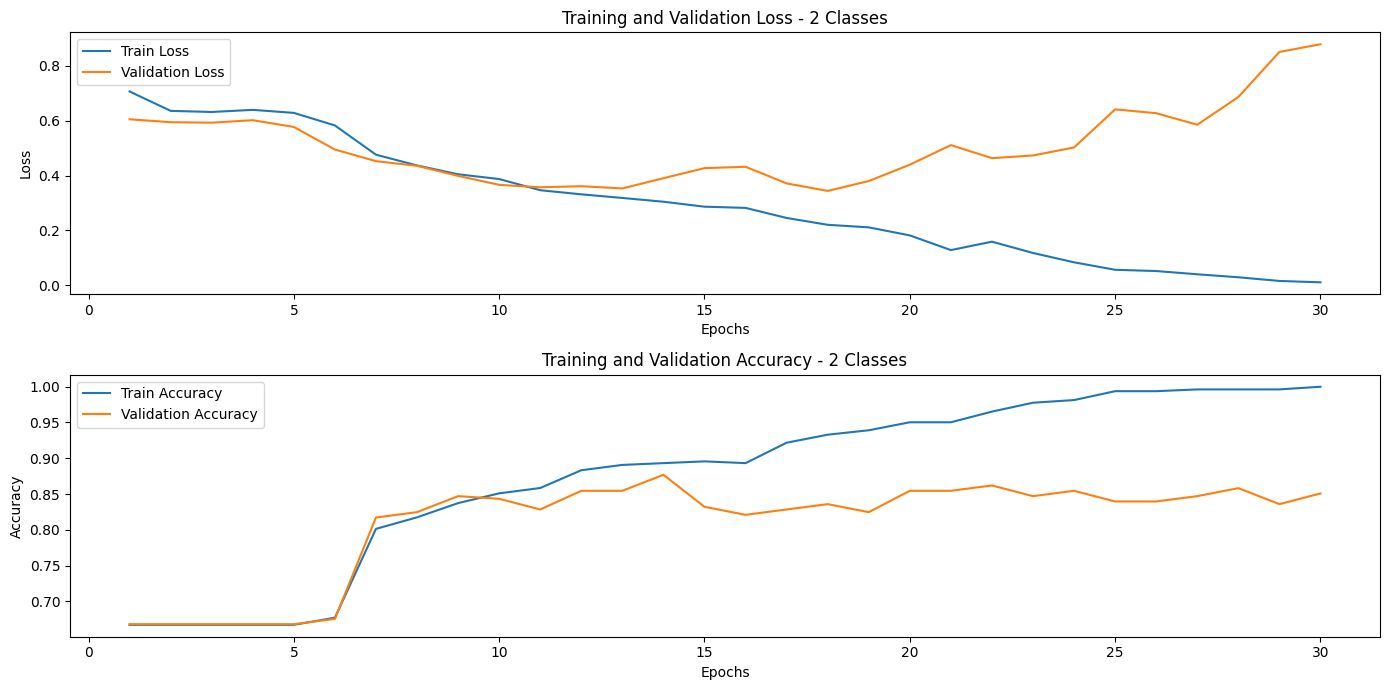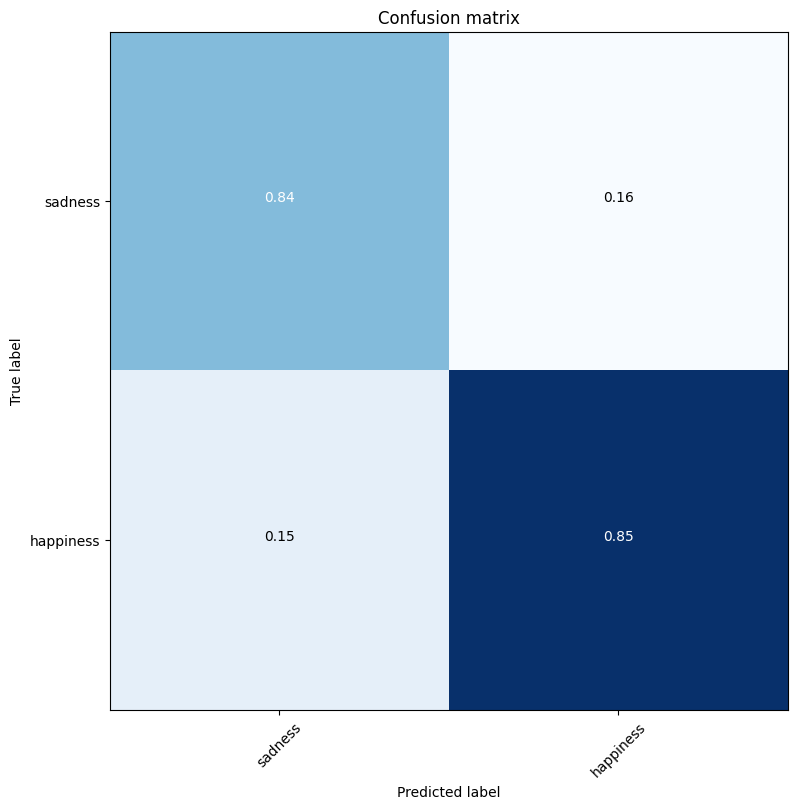

In [ ]:
# Residual block model with unbalanced data
use_cuda = True
num_classes = 2
combined_model = CNNetResidual3(2,8,12)
Model1 = trainmodel(combined_model, balanced_train_dataset, combined_val_dataset, batch=64, learningRate=0.0001, num_epochs=30, num_classes=2)

Final Epoch: Train Acc: 1.00, Train Loss: 0.0038 | Val Acc: 0.84, Val Loss: 0.5152

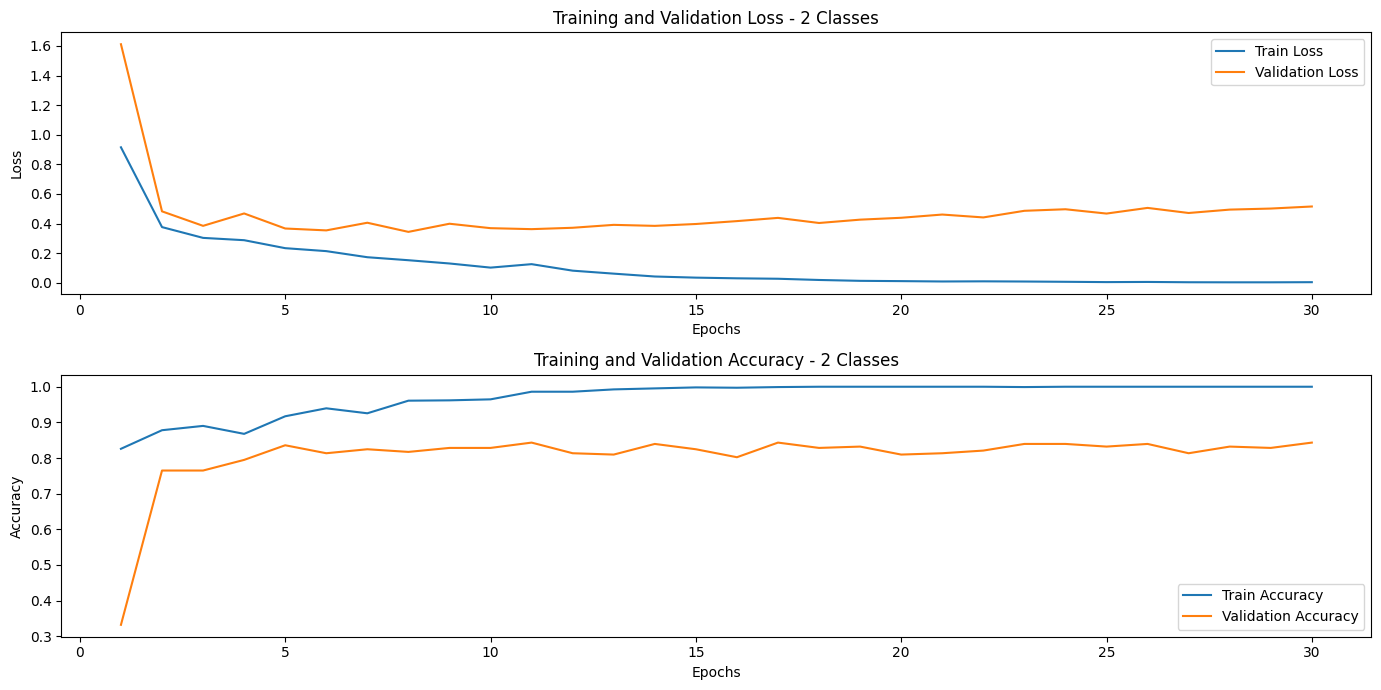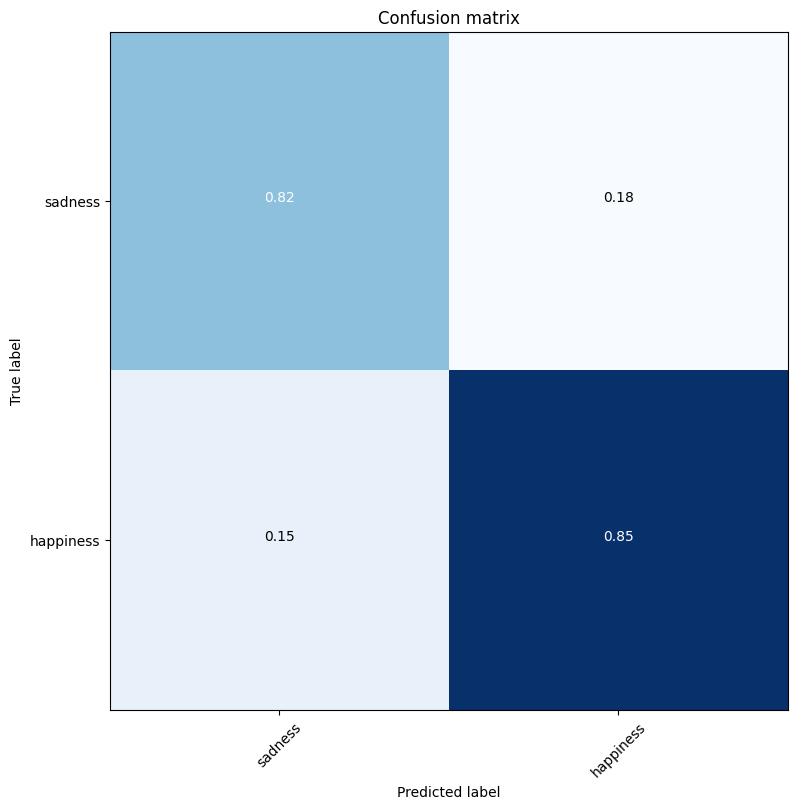

In [ ]:
# Normal CNN model with not balanced data
use_cuda = True
num_classes = 2
combined_model = CombinedCNN(2)
Model1 = trainmodel(combined_model, combined_train_dataset, combined_val_dataset, batch=64, learningRate=0.0005, num_epochs=30, num_classes=2)

Final Epoch: Train Acc: 1.00, Train Loss: 0.0205 | Val Acc: 0.82, Val Loss: 1.0305

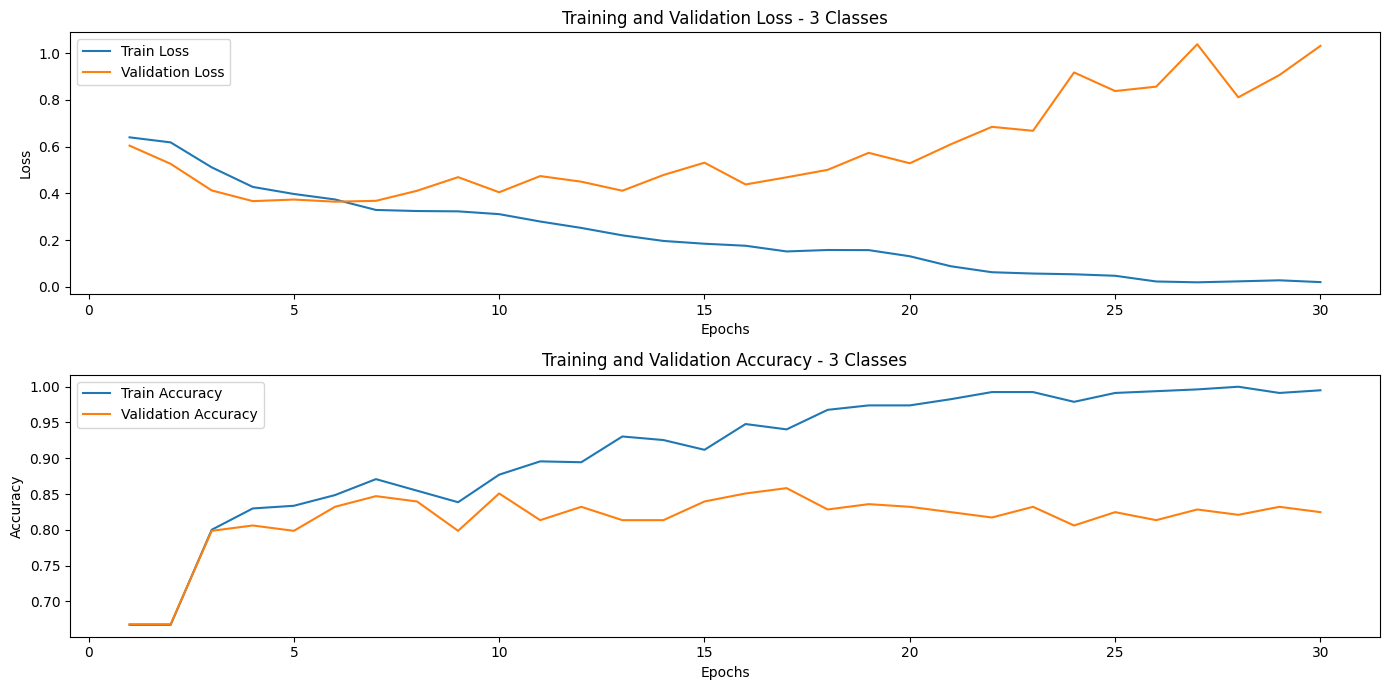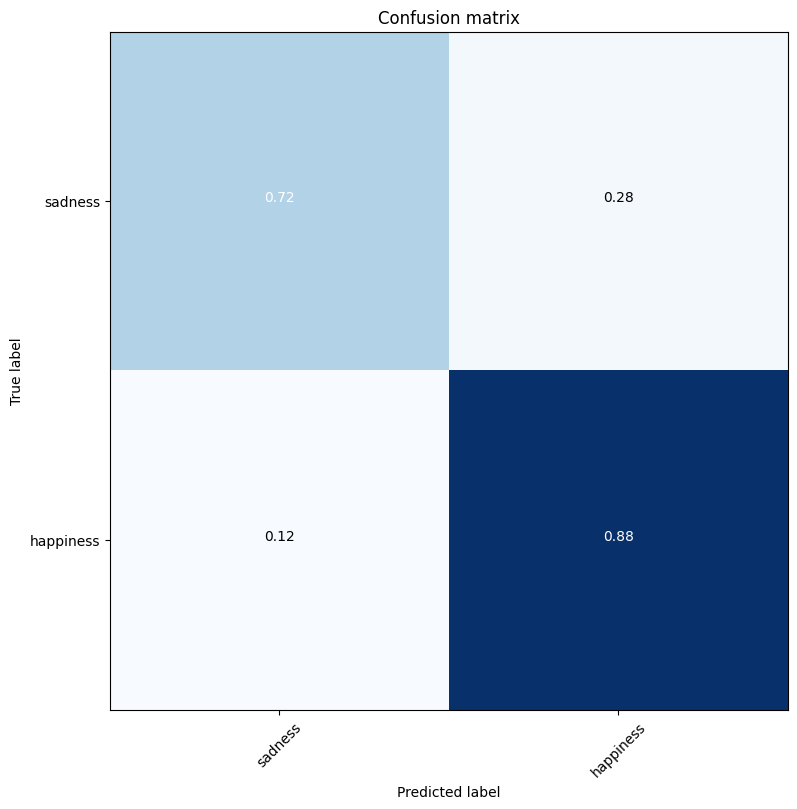

### Test accuracy of your best model under 2 classes

In [ ]:
def testevaluate(model, loader):
    """ Evaluate the network """
    correct = 0
    total = 0

    model.eval()  # Set the model to evaluation mode

    for inputs, labels in loader:
        inputs = inputs.unsqueeze(0)
        inputs = inputs.cuda()  # Move inputs to GPU
        labels = labels.cuda()  # Move labels to GPU

        outputs = model(inputs)
        predicted = outputs.max(1, keepdim=True)[1]
        total += inputs.shape[0]
        correct += predicted.eq(labels.view_as(predicted)).sum().item()


    model.train()  # Set the model back to training mode
    return correct / total

In [ ]:
# load your best model
best_model2class = CombinedCNN(2)
best_model2class.load_state_dict(torch.load('/content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr0.0005_epoch13.pt'))

<All keys matched successfully>

In [ ]:
# give the accuracy for test data
use_cuda = True
test_acc = testevaluate(best_model2class, combined_test_dataset)
print("Test Acc {:.2f}%".format(test_acc))

Test Acc 0.84%


### Quantitative Results for 2 classes: Happiness and Sad

The best accuracy for 2 classes is balance data with normal CNN model, best validation accuracy 0.88, with corresponding test data accuracy 0.84. The correspoding unbalance data has best validation accuracy 0.86. But the model with residual block's accuracy is slighter lower then normal CNN model. The corresponding code is as follow.

## Let's try 4 class with Sad, Surprise, Happy and Anger

In [ ]:
# Four classes: sadness, surprise, happiness, anger
features_or_array = np.array(features_or)  # Convert features to a NumPy array for indexing
labels_or_array = np.array(labels_or)  # Convert labels to a NumPy array for indexing

# Define the labels you want to extract
#desired_labels = [1, 2, 5, 6]
desired_labels = [1, 3, 5, 6]

# Create a mask to filter the indices corresponding to the desired labels
mask = np.isin(labels_or_array, desired_labels)

# Extract features and labels corresponding to the desired labels
features_filtered = features_or_array[mask]
labels_filtered = labels_or_array[mask]
# Verify the shapes and sizes of the extracted features and labels
label_counts_or_filtered = Counter(labels_filtered)
for label, count in label_counts_or_filtered.items():
    print(f"Label {label} {classeses[label]}: {count} images")
print("Filtered Features Shape:", features_filtered.shape)
print("Filtered Labels Shape:", labels_filtered.shape)

Label 1 sadness: 448 images
Label 3 surprise: 610 images
Label 5 happiness: 896 images
Label 6 anger: 585 images
Filtered Features Shape: (2539, 224, 224)
Filtered Labels Shape: (2539,)


In [ ]:
'''labels_filtered = np.array(labels_filtered)

# Change value 1 to 0 and value 5 to 1
labels_filtered[labels_filtered == 1] = 0
labels_filtered[labels_filtered == 3] = 1
labels_filtered[labels_filtered == 5] = 2
labels_filtered[labels_filtered == 6] = 3
np.unique(labels_filtered)

array([0, 1, 2, 3])

In [ ]:
# Prepare datasets for eyes, eyebrows, and mouth
combined_train_dataset, combined_val_dataset, combined_test_dataset = split_and_prepare_dataset(features_filtered, labels_filtered, transform)

# Balance the train data
balanced_train_dataset = balance_dataset_with_augmentation(combined_train_dataset, augmentation_transforms)
balanced_train_labels = balanced_train_dataset.tensors[1].numpy()
# Count the number of images for each unique label in the balanced dataset
label_counts_balanced = Counter(balanced_train_labels)
# Print the counts for each label
for label, count in label_counts_balanced.items():
    print(f"Label {label} ({classes[label]}): {count} images")

Label 0 (neutrality): 537 images
Label 1 (sadness): 537 images
Label 2 (fear): 537 images
Label 3 (surprise): 537 images


In [ ]:
# Residual block model with balanced data
use_cuda = True
combined_model = CNNetResidual3(4,8,12)
combined_model.cuda()
Model1 = trainmodel(combined_model, balanced_train_dataset, combined_val_dataset, batch=64, learningRate=0.00001, num_epochs=40, num_classes=4)

Final Epoch: Train Acc: 0.99, Train Loss: 0.1349 | Val Acc: 0.65, Val Loss: 0.9988

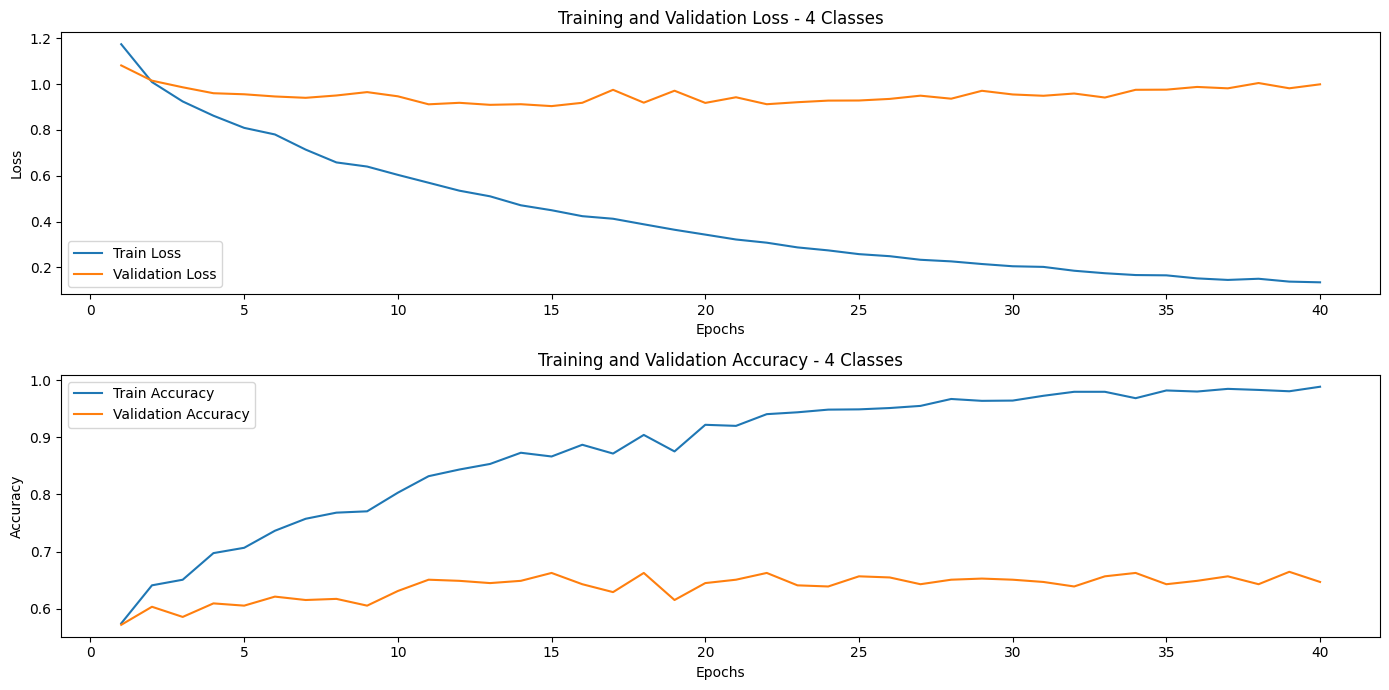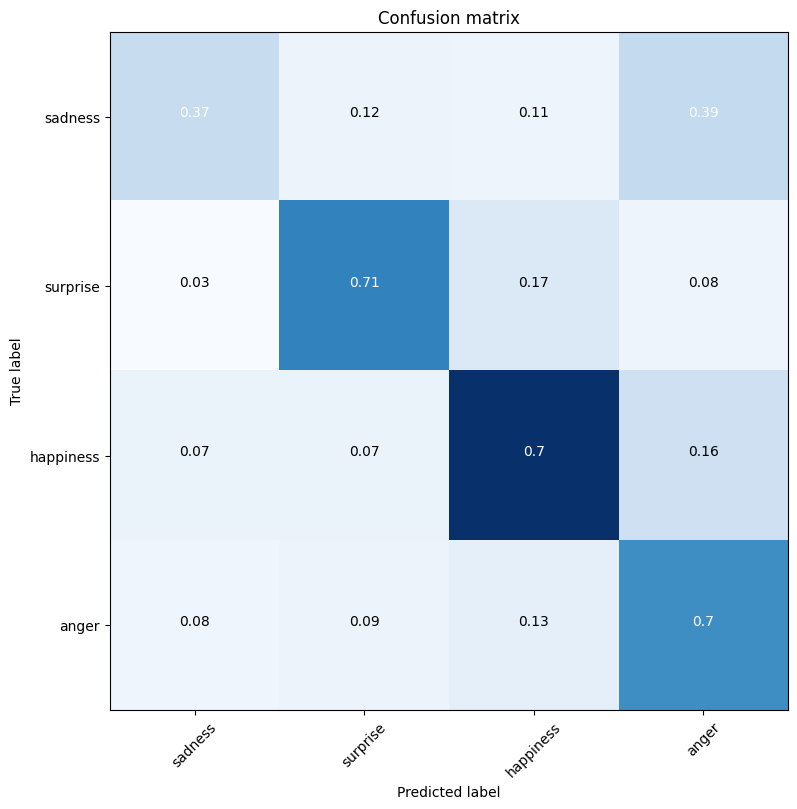

In [ ]:
# Normal CNN with balanced data
use_cuda = True
combined_model = CombinedCNN(4)
combined_model.cuda()
Model1 = trainmodel(combined_model, balanced_train_dataset, combined_val_dataset, batch=64, learningRate=0.0001, num_epochs=40, num_classes=4)

Final Epoch: Train Acc: 0.92, Train Loss: 0.2216 | Val Acc: 0.66, Val Loss: 1.3972

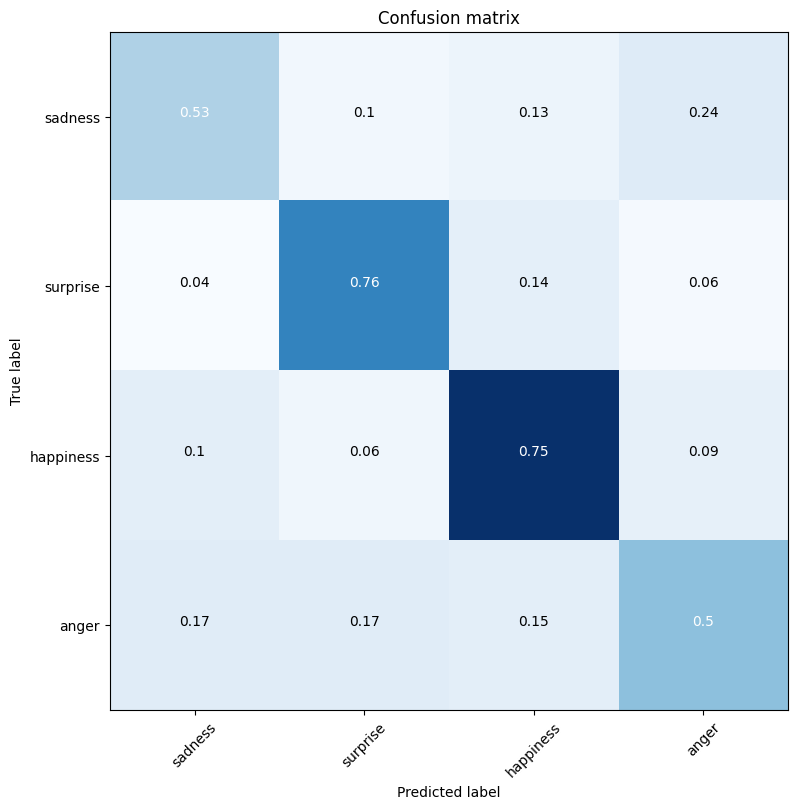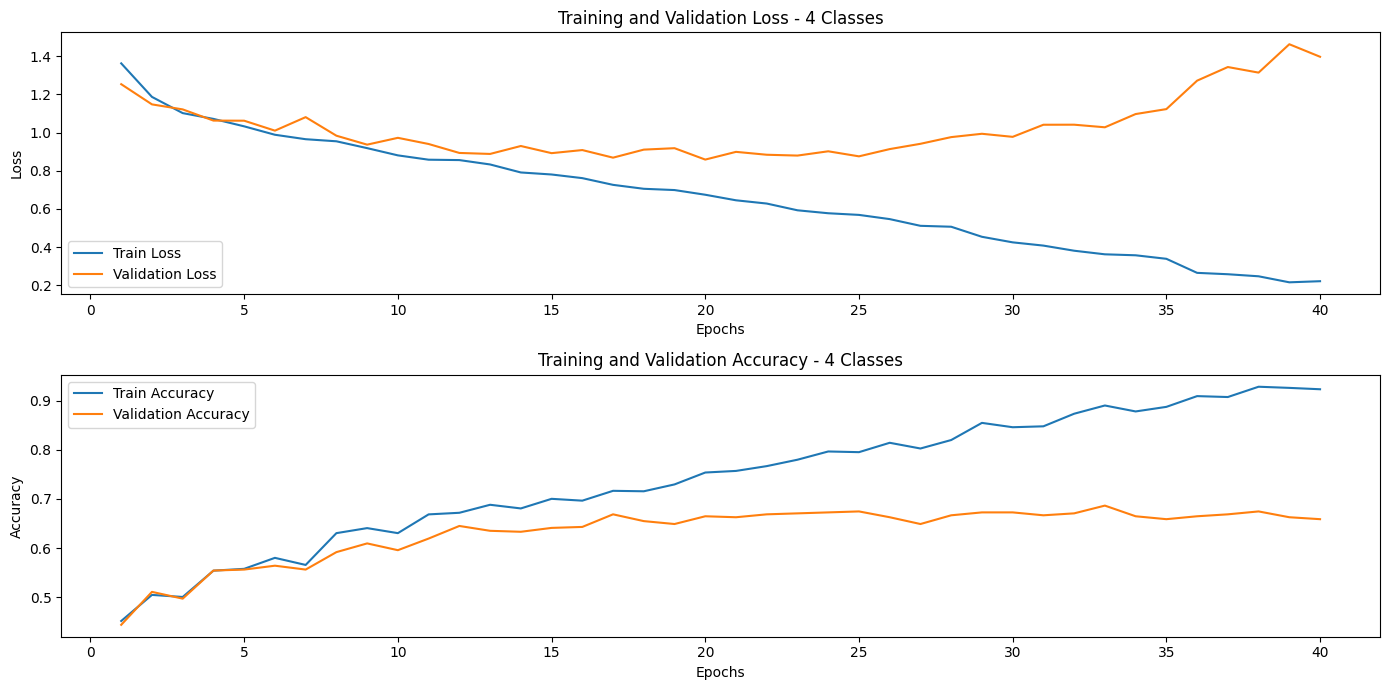

In [ ]:
# Normal CNN with unbalanced data
use_cuda = True
combined_model = CombinedCNN(4)
combined_model.cuda()
Model1 = trainmodel(combined_model, combined_train_dataset, combined_val_dataset, batch=64, learningRate=0.0001, num_epochs=40, num_classes=4)

Final Epoch: Train Acc: 0.95, Train Loss: 0.1248 | Val Acc: 0.63, Val Loss: 1.5062

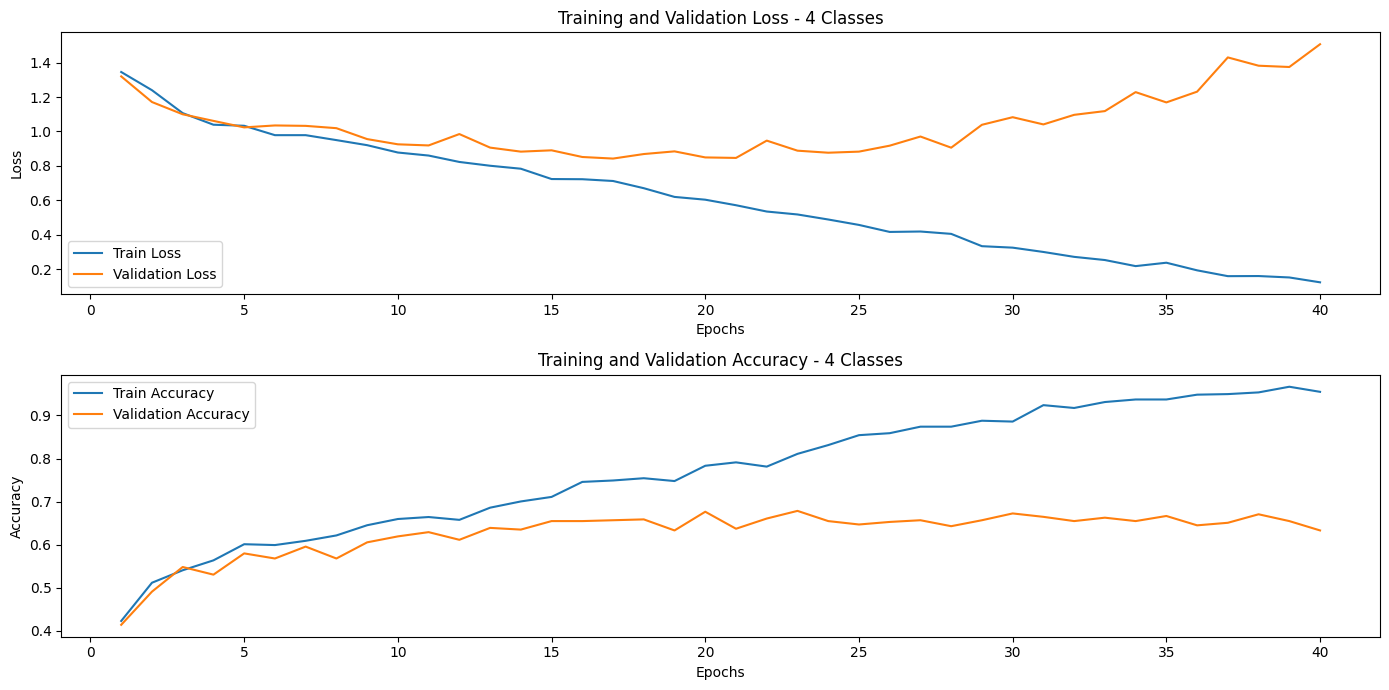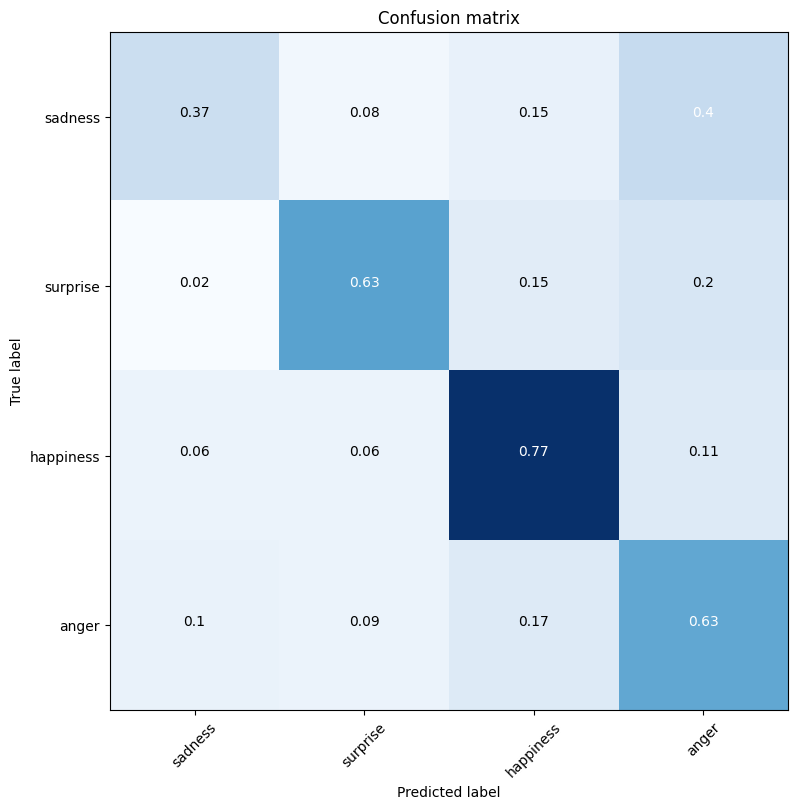

In [ ]:
# load  best model
best_model4class = CombinedCNN(4)
best_model4class.cuda()
best_model4class.load_state_dict(torch.load('/content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN4class69_bs64_lr0.0001_epoch32.pt'))

<All keys matched successfully>

### Quantitative Results for 4 classes Happiness, Sad, Surprise and Anger

The best accuracy for 4 classes is balance data with normal CNN model, best validation accuracy 0.69, with corresponding test data accuracy 0.65. The correspoding unbalance data has best validation accuracy 0.67. But the model with residual block's accuracy is slighter lower then normal CNN model, with best accuracy 0.67. We surpringly find balanced data set does not increase total accuracy much. But it indeed change some emotion accuracy. Before the data has been balanced the accuracy for Sade, surprise , happy and anger emotion is 0.37, 0.63, 0.77, 0.63. After balance the corresponding accuracy has been changed to 0.53, 0.76, 0.75, 0.5.

In [ ]:
test_acc = testevaluate(best_model4class, combined_test_dataset)
print("Test Acc {:.2f}%".format(test_acc))

Test Acc 0.65%


## Next, We will try all of 8 classes with neutrality, surprise, anger, contempt, sadness, fear, happiness, and disgust

In [ ]:
# Four classes: neutrality, sadness, fear, anger
features_or_array = np.array(features_or)  # Convert features to a NumPy array for indexing
labels_or_array = np.array(labels_or)  # Convert labels to a NumPy array for indexing

# Verify the shapes and sizes of the extracted features and labels
label_counts_or_filtered = Counter(labels_or_array)
for label, count in label_counts_or_filtered.items():
    print(f"Label {label} {classeses[label]}: {count} images")
print("Filtered Features Shape:", features_or_array.shape)
print("Filtered Labels Shape:", labels_or_array.shape)

Label 0 neutrality: 419 images
Label 1 sadness: 448 images
Label 2 fear: 372 images
Label 3 surprise: 610 images
Label 4 contempt: 142 images
Label 5 happiness: 896 images
Label 6 anger: 585 images
Label 7 disgust: 292 images
Filtered Features Shape: (3764, 224, 224)
Filtered Labels Shape: (3764,)


In [ ]:
# Prepare datasets for eyes, eyebrows, and mouth
combined_train_dataset, combined_val_dataset, combined_test_dataset = split_and_prepare_dataset(features_or_array, labels_or_array, transform)

# Balance the train data
balanced_train_dataset = balance_dataset_with_augmentation(combined_train_dataset, augmentation_transforms)
balanced_train_labels = balanced_train_dataset.tensors[1].numpy()
# Count the number of images for each unique label in the balanced dataset
label_counts_balanced = Counter(balanced_train_labels)
# Print the counts for each label
for label, count in label_counts_balanced.items():
    print(f"Label {label} ({classes[label]}): {count} images")

Label 0 (neutrality): 537 images
Label 1 (sadness): 537 images
Label 2 (fear): 537 images
Label 3 (surprise): 537 images
Label 4 (contempt): 537 images
Label 5 (happiness): 537 images
Label 6 (anger): 537 images
Label 7 (disgust): 537 images


In [ ]:
use_cuda = True
combined_model = CNNetResidual3(8,16,16)
combined_model.cuda()
Model1 = trainmodel(combined_model, balanced_train_dataset, combined_val_dataset, batch=64, learningRate=0.00001, num_epochs=40, num_classes=8)

Final Epoch: Train Acc: 0.95, Train Loss: 0.3226 | Val Acc: 0.45, Val Loss: 1.7123

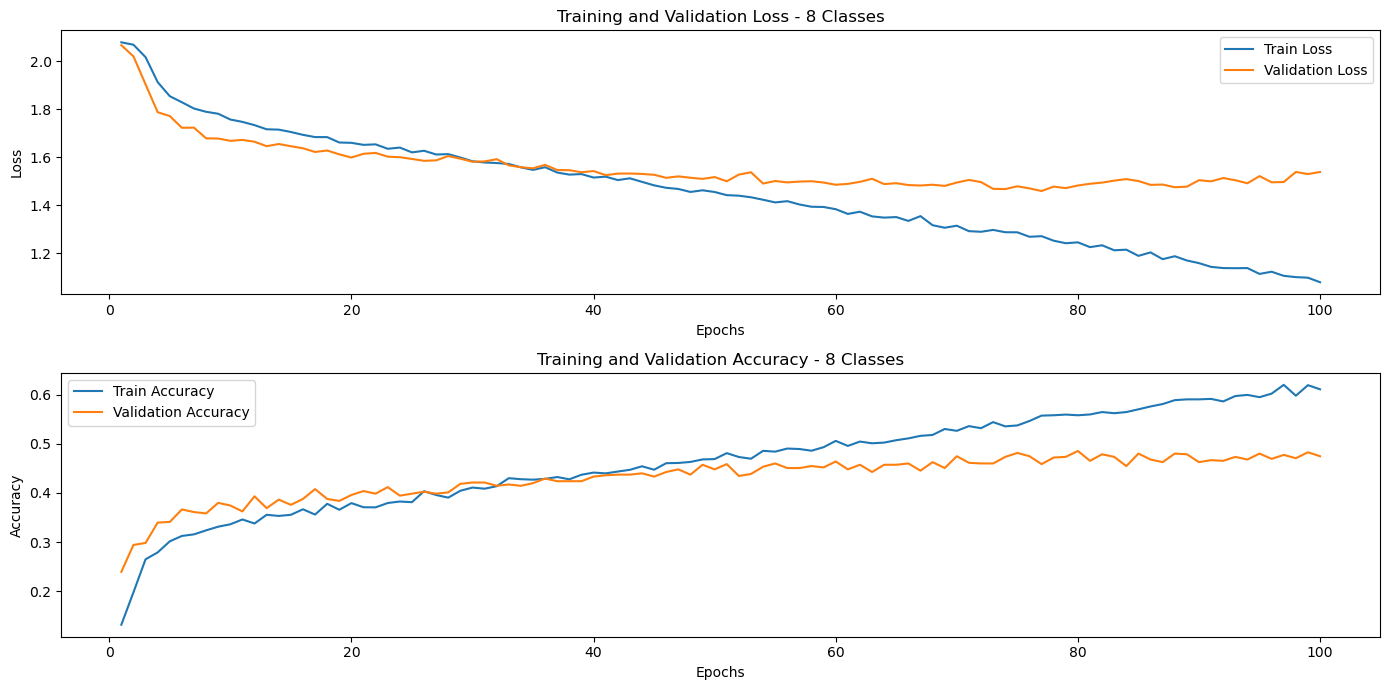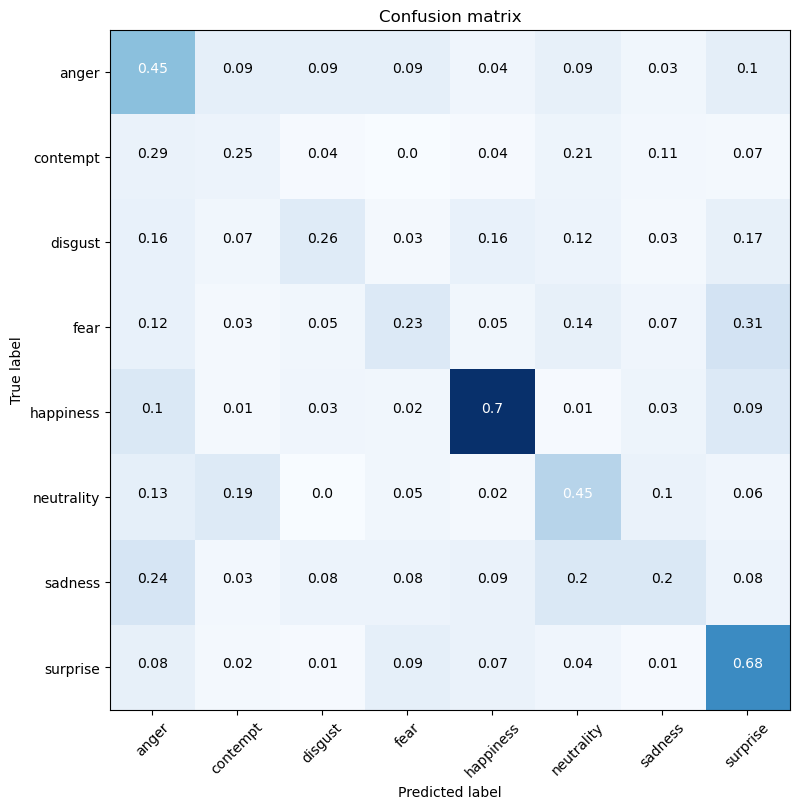

In [ ]:
use_cuda = True
combined_model = CombinedCNN(8)
combined_model.cuda()
Model1 = trainmodel(combined_model, balanced_train_dataset, combined_val_dataset, batch=64, learningRate=0.0001, num_epochs=40, num_classes=8)

Training Begin...

Epoch 1: Train Acc: 0.17, Train Loss: 2.0778 | Val Acc: 0.27, Val Loss: 2.0629
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr1e-05_epoch0
Epoch 2: Train Acc: 0.22, Train Loss: 2.0602 | Val Acc: 0.29, Val Loss: 2.0043
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr1e-05_epoch1
Epoch 3: Train Acc: 0.27, Train Loss: 1.9721 | Val Acc: 0.30, Val Loss: 1.9025
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr1e-05_epoch2
Epoch 4: Train Acc: 0.31, Train Loss: 1.8775 | Val Acc: 0.34, Val Loss: 1.8120
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr1e-05_epoch3
Epoch 5: Train Acc: 0.32, Train Loss: 1.8343 | Val Acc: 0.36, Val Loss: 1.7897
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CombinedCNN_bs64_lr1e-05_epoch4
Epoch 6: Train Acc: 0.33, Train Loss: 1.7982 | Val Acc: 

KeyboardInterrupt: ignored

### Quantitative Results for 8 classes
The best accuracy for 8 classes is balance data with normal CNN model, best validation accuracy 0.54, with corresponding test data accuracy 0.45. The correspoding unbalance data has best validation accuracy 0.50. But the model with residual block's accuracy is slighter lower then normal CNN model, with best accuracy 0.51. Better the overfitting for residual block is much slower than before, which demonstrate as the number of imges goes up, the performance of Residual block Model is improving.

## Test New Data

The new dataset from kaggle consists of images capturing people displaying 7 distinct emotions (anger, contempt, disgust, fear, happiness, sadness and surprise). We will try to use our best model from 4 classes(happiness,sadness,suprise and anger) to test the new dataset.

Crop and resize the new dataset

In [ ]:
def crop_and_resize_faces(root_folder, target_size=(224, 224)):
    image_data = []  # List to store resized image data
    image_labels = []  # List to store image labels (file names)

    # Create a face detector from dlib
    face_detector = dlib.get_frontal_face_detector()

    # Iterate through all subfolders in the root folder
    for folder in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder)

        # Check if the item in the root folder is a directory
        if os.path.isdir(folder_path):
            # Iterate through all files in the subfolder
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)

                # Check if the file is an image
                if file_name.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
                    # Read the image using OpenCV
                    image = cv2.imread(file_path)

                    # Convert the BGR image to RGB
                    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    # Detect faces in the image
                    faces = face_detector(image_rgb)

                    # Check if any faces are detected
                    if len(faces) > 0:
                        # Get the bounding box of the first face
                        face_bbox = faces[0]

                        # Crop the face from the image
                        cropped_face = image_rgb[face_bbox.top():face_bbox.bottom(), face_bbox.left():face_bbox.right()]

                        # Resize the cropped face
                        resized_face = cv2.resize(cropped_face, target_size)

                        # Extract label name without file extension and convert to lowercase
                        label = os.path.splitext(file_name)[0].lower()

                        # Append resized face and label to lists
                        image_data.append(Image.fromarray(resized_face))
                        image_labels.append(label)

    return image_data, image_labels

# Initialize Dlib's face detector (HOG-based) and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/gdrive/My Drive/ColabNotebooks/shape_predictor_68_face_landmarks.dat')

# Function to extract and combine eyes, eyebrows, and mouth into a single image
def extract_and_combine_regions(gray, landmarks):
    # Create masks for eyes including eyebrows and mouth
    mask_eyes_eyebrows = np.zeros_like(gray)
    mask_mouth = np.zeros_like(gray)

    # Points for eyes and eyebrows
    eyes_eyebrows_points = np.concatenate([
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 27)]),  # Eyebrows
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 48)])   # Eyes
    ])

    # Points for mouth
    mouth_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)])  # Mouth

    # Fill the masks with the polygons defined by points
    cv2.fillPoly(mask_eyes_eyebrows, [eyes_eyebrows_points], 255)
    cv2.fillPoly(mask_mouth, [mouth_points], 255)

    # Use the masks to extract the regions from the image
    eyes_eyebrows_region = cv2.bitwise_and(gray, mask_eyes_eyebrows)
    mouth_region = cv2.bitwise_and(gray, mask_mouth)

    # Combine the regions on a black background
    combined_image = np.zeros_like(gray)
    combined_image[mask_eyes_eyebrows == 255] = eyes_eyebrows_region[mask_eyes_eyebrows == 255]
    combined_image[mask_mouth == 255] = mouth_region[mask_mouth == 255]

    return combined_image

# Specify the root folder containing subfolders with images
root_folder = '/content/gdrive/My Drive/ColabNotebooks/origina'

# Read, crop, and resize faces, and get labels
cropped_and_resized_faces, labels = crop_and_resize_faces(root_folder)


In [ ]:
label_mapping = {
    'neutral': 0,
    'sad': 1,
    'fear': 2,
    'surprised': 3,
    'contempt': 4,
    'happy': 5,
    'anger': 6,
    'disgust': 7
}

# Convert labels to integers
labels_as_int = [label_mapping[label] for label in labels]


display the image from new dataset

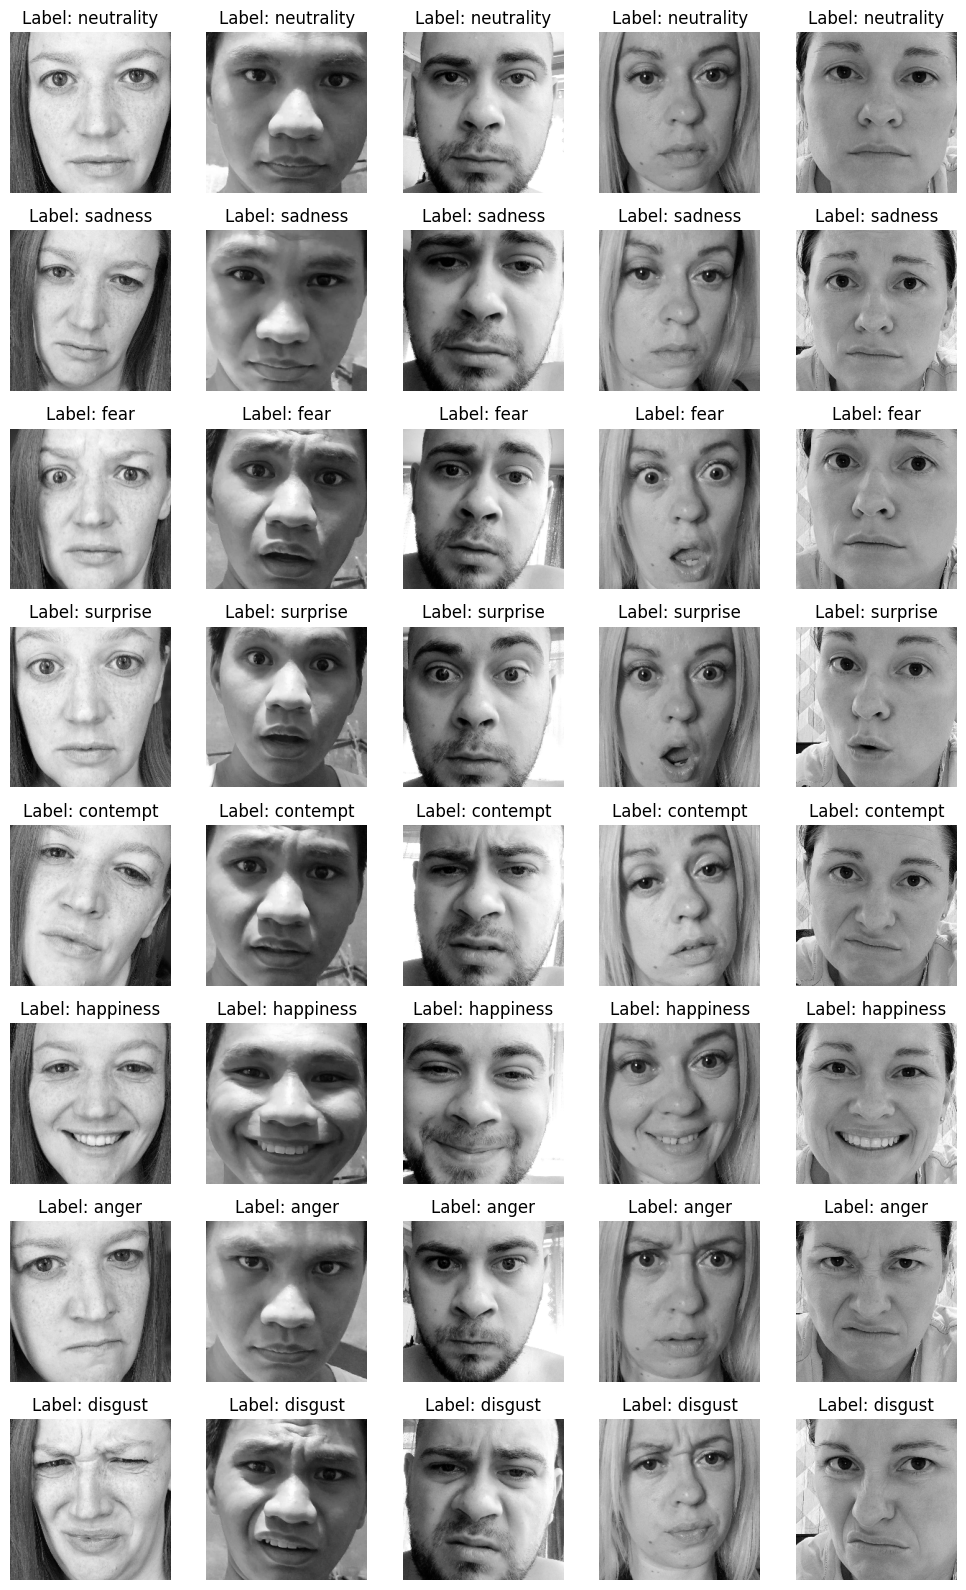

In [ ]:
cropped_and_resized_faces_gray = [image.convert('L') for image in cropped_and_resized_faces]
plot_first_n_images(cropped_and_resized_faces_gray, labels_as_int, classeses, n=5)

Extract eye, eyebrow and mouth from our new dataset

In [ ]:
extracted_regions_new = []
features_new = []
labels_new = []
train_data_new = []
failed_indices_new = []

def create_imagesnew():
    for i, gray_image in enumerate(cropped_and_resized_faces_gray):
        label = labels_as_int[i]  # Use the index of the class as the label

        # Ensure that gray_image is a numpy array
        gray_image_np = np.array(gray_image)

        # Apply CLAHE to improve the contrast locally
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray_clahe = clahe.apply(gray_image_np)

        # Detect faces in the CLAHE preprocessed image
        faces = detector(gray_clahe, 1)

        # If no faces are detected with CLAHE, try standard histogram equalization
        if len(faces) == 0:
            gray_eq = cv2.equalizeHist(gray_image_np)
            faces = detector(gray_eq, 1)
            image_to_use = gray_eq
        else:
            image_to_use = gray_clahe

        if len(faces) > 0:
            face = faces[0]
            landmarks = predictor(image_to_use, face)
            combined_region = extract_and_combine_regions(image_to_use, landmarks)

            # Append the combined image and its label to the list
            features_new.append(combined_region)  # Append the combined region
            labels_new.append(label)

            train_data_new.append([combined_region, label])
        else:
            failed_indices_new.append(i)

create_imagesnew()


In [ ]:
label_counts = Counter(labels_new)
for label, count in label_counts.items():
    print(f"Label {label} {classeses[label]}: {count} images")

Label 0 neutrality: 9 images
Label 5 happiness: 9 images
Label 6 anger: 8 images
Label 7 disgust: 10 images
Label 3 surprise: 10 images
Label 1 sadness: 8 images
Label 4 contempt: 10 images
Label 2 fear: 10 images


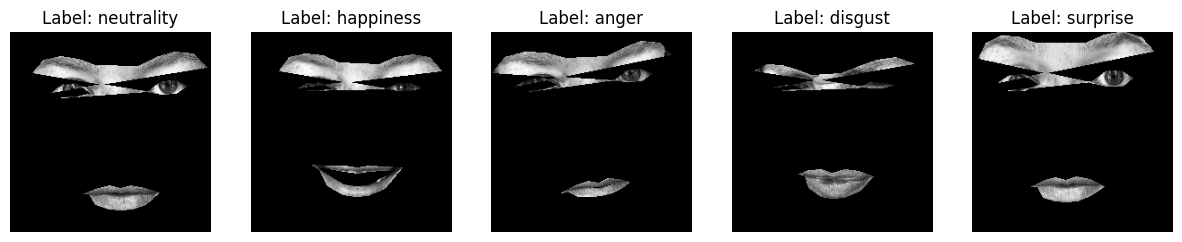

In [ ]:
def plot_first_n_images(images, labels, classes, n):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))

    # Plot the first n images
    for img_idx, img_index in enumerate(range(n)):
        axes[img_idx].imshow(images[img_index], cmap='gray')
        axes[img_idx].set_title(f"Label: {classes[labels[img_index]]}")
        axes[img_idx].axis('off')

    plt.show()

# Example usage
plot_first_n_images(features_new, labels_new, classeses, n=5)


In [ ]:
# Four classes: sadness, surprise, anger，happy
features_or_array_new = np.array(features_new)  # Convert features to a NumPy array for indexing
labels_or_array_new = np.array(labels_new)  # Convert labels to a NumPy array for indexing

# Define the labels you want to extract
desired_labels_new = [1, 3, 5, 6]

# Create a mask to filter the indices corresponding to the desired labels
mask = np.isin(labels_or_array_new, desired_labels_new)

# Extract features and labels corresponding to the desired labels
features_filtered_new = features_or_array_new[mask]
labels_filtered_new = labels_or_array_new[mask]

In [ ]:
labels_filtered_new = np.array(labels_filtered_new)

# Change value 1 to 0 and value 5 to 1
labels_filtered_new[labels_filtered_new == 1] = 0
labels_filtered_new[labels_filtered_new == 3] = 1
labels_filtered_new[labels_filtered_new == 5] = 2
labels_filtered_new[labels_filtered_new == 6] = 3
np.unique(labels_filtered_new)

array([0, 1, 2, 3])

Test result under 4 classes

In [ ]:
test_new = prepare_dataset(features_filtered_new, labels_filtered_new, transform)

In [ ]:
use_cuda = True
best_model4class.cuda()
test_acc = testevaluate(best_model4class, test_new)
print("Test Acc {:.2f}%".format(test_acc))


Test Acc 0.31%


Let's try two classes only with happiness and sadness

In [ ]:
# Four classes: sadness, surprise, anger，happy
features_or_array_new = np.array(features_new)  # Convert features to a NumPy array for indexing
labels_or_array_new = np.array(labels_new)  # Convert labels to a NumPy array for indexing

# Define the labels you want to extract
desired_labels_new = [1,5]

# Create a mask to filter the indices corresponding to the desired labels
mask = np.isin(labels_or_array_new, desired_labels_new)

# Extract features and labels corresponding to the desired labels
features_filtered_new = features_or_array_new[mask]
labels_filtered_new = labels_or_array_new[mask]

In [ ]:
labels_filtered_new = np.array(labels_filtered_new)

# Change value 1 to 0 and value 5 to 1
labels_filtered_new[labels_filtered_new == 1] = 0
labels_filtered_new[labels_filtered_new == 5] = 1
np.unique(labels_filtered_new)

array([0, 1])

In [ ]:
test_new = prepare_dataset(features_filtered_new, labels_filtered_new, transform)

In [ ]:
use_cuda = True
best_model2class.cuda()
test_acc = testevaluate(best_model2class, test_new)
print("Test Acc {:.2f}%".format(test_acc))

Test Acc 1.00%


### Discussion on new data

We got 100% accuracy on two-class (happiness and sadness) while only achieving 31% on a four-class problem (happiness, sadness, surprise, and anger), this could be due to below several reason:

1, Binary classification is generally easier than multi-class classification because the decision boundary is between two classes instead of multiple overlapping boundaries.

2, Human emotions are complex and sometimes subtle, making them inherently difficult to categorize. Sadness could be blend with fear and discuss. Also the month for sadness is really similiar with anger.

3, Our training data lacked this diversity as average 500 images for each class, so the model might not recognize these expressions accurately.

4, We should focus more area like nose where this area change shape and movement significantly with different emotions

## Future Improvement:

Data Expansion: Our current dataset, comprising 5500 images, presents a limitation due to its size and imbalance. Acquiring a larger, more balanced dataset is pivotal for enhancing the robustness of the model.

Feature Enrichment: The incorporation of additional facial regions, such as the nose, may provide more nuanced data, potentially leading to improved accuracy in emotion detection.

Original Image Augmentation: While traditional data augmentation techniques offered limited benefits, increasing the dataset with more original images could be a more effective strategy for improving model performance.

Cultural Sensitivity in Expression Recognition: Recognizing the diversity in emotional expression across different ethnicities, further analysis is essential to ensure the model's adaptability and sensitivity to varied demographic groups.

Temporal-Spatial Architectures: Exploring deep learning architectures that leverage both temporal and spatial data—such as Combined CNN-LSTM Architectures—can offer a more dynamic understanding of facial expressions over time.

## Conclusion:

Our project's results highlight the complex challenges of recognizing emotions through facial expressions. Although our model achieved reasonable accuracy, the performance varied across different emotions, indicating a need for further improvement. The limited ability of the model to accurately interpret a new dataset underscores the importance of a larger and more diverse set of training data, as well as more advanced modeling techniques.


The project has shed light on the delicate balance between data representation and the interpretive power of the model. The next step is clear: we must expand our dataset to better capture the vast array of human expressions. Adding more facial features could provide a richer dataset, increasing the model's ability to discern emotions accurately.

Furthermore, incorporating cultural nuances and exploring architectures that consider the temporal dynamics of facial expressions are promising areas for future research. These advancements will not only enhance the accuracy of our model but also ensure its ethical application across diverse populations.

## Citation

1. Huang, Z. Y., Chiang, C. C., Chen, J. H., et al. (2023).
A study on computer vision for facial emotion recognition.
Scientific Reports, 13, 8425.
https://doi.org/10.1038/s41598-023-35446-4

2. Yolcu, G., Oztel, I., Kazan, S., Oz, C., Palaniappan, K., Lever, T. E., & Bunyak, F. (2019).
Facial expression recognition for monitoring neurological disorders based on convolutional neural network.
Multimedia Tools and Applications, 78(22), 31581-31603.
https://doi.org/10.1007/s11042-019-07959-6

3. Jain, D. K., Shamsolmoali, P., & Sehdev, P. (2019).
Extended deep neural network for facial emotion recognition.
Pattern Recognition Letters, 120, 69-74.
https://doi.org/10.1016/j.patrec.2019.01.008

4. Teixeira Lopes, A., de Aguiar, E., De Souza, A. F., & Oliveira-Santos, T. (2017).
Facial expression recognition with Convolutional Neural Networks: Coping with few data and the training sample order.
Pattern Recognition, 61, 610-628.
https://doi.org/10.1016/j.patcog.2016.07.026

5. Mellouk, W., & Handouzi, W. (2020). Facial emotion recognition using deep learning: review and insights. Procedia Computer Science, 175, 689-694.
https://doi.org/10.1016/j.procs.2020.07.101